# Halofit Emulation
Author: João Victor Rebouças, May 2023

In [1]:
from time import perf_counter
import numpy as np
import matplotlib.pyplot as plt
import keras
import euclidemu2 as ee2
import train_utils as utils
from train_utils import params, lims, ref
# Don't worry about tensorflow warnings

2023-07-12 14:28:05.044870: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-12 14:28:05.070474: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Train redshifts
redshifts = [z for z in utils.redshifts if z <= 3]

### Data preprocessing
**How to use**: select the desired dataset in `path_to_train` and run all subsequent cells until the [training section](#Training).

**Pipeline description**:
- Load chosen training data
- Smear BAO in linear $P(k)$ (using BACCO's code)
- Calculate $Q(k) = \log(P_\mathrm{NL}/P_\mathrm{lin,\, smear})$
- Normalize cosmological parameters based on EE2 box boundaries
- Normalize $Q$ using min-max
- Save $Q$ normalization parameters (for rescaling $Q$ after emulation)
- PCA

In [3]:
# Data can be downloaded at https://github.com/SBU-Jonathan/halofit_data
# LCDM datasets
path_to_spectra = "/home/grads/data/jonathan/cola_projects/COLA_output/"
path_to_train_lcdm = path_to_spectra + "LCDM/400_1"

# wCDM datasets
path_to_train_wcdm = path_to_spectra + "WCDM/500_1"

In [4]:
# Select which training dataset to use
path_to_train = path_to_train_lcdm
ks = utils.ks_cola_default
ks_above_z2 = ks[:256]

In [10]:
# Load training LHS
path_to_lcdm_lhs = "/home/grads/data/jonathan/cola_projects/COLA_input/LCDM/400_1/lhs.txt"
train_samples = np.loadtxt(path_to_lcdm_lhs)
print(train_samples[0])

[2.98998249e-01 5.84627549e-02 9.66097472e-01 1.99213595e-09
 6.75717014e-01]


In [11]:
# Load ref cosmology from CAMB, all redshifts
pk_lin_ref = np.zeros((len(redshifts), len(ks)))
pk_nl_a_ref = np.zeros((len(redshifts), len(ks)))
pk_nl_b_ref = np.zeros((len(redshifts), len(ks)))
pk_lin_smear_ref = np.zeros((len(redshifts), len(ks)))
for i, redshift in enumerate(redshifts):
    pk_nl_a_ref[i], pk_lin_ref[i] = np.loadtxt(f"{path_to_train}/a/output/ref/pofk_ref_total_z{redshift:.3f}.txt", unpack=True, max_rows=len(ks), usecols=(1,2))
    pk_nl_b_ref[i], pk_lin_ref[i] = np.loadtxt(f"{path_to_train}/b/output/ref/pofk_ref_total_z{redshift:.3f}.txt", unpack=True, max_rows=len(ks), usecols=(1,2))
    pk_lin_smear_ref[i] = utils.smear_bao(ks, pk_lin_ref[i], utils.smooth_bao(ks, pk_lin_ref[i]), par=0.5)
pk_nl_ref = (pk_nl_a_ref + pk_nl_b_ref)/2

/tmp/ipykernel_1214557/1375946456.py:7: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=512`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  pk_nl_a_ref[i], pk_lin_ref[i] = np.loadtxt(f"{path_to_train}/a/output/ref/pofk_ref_total_z{redshift:.3f}.txt", unpack=True, max_rows=len(ks), usecols=(1,2))
/tmp/ipykernel_1214557/1375946456.py:8: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=512`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please s

In [12]:
ref_params = {
    "h": 0.67,
    "Omm": 0.319,
    "Omb": 0.049,
    "As": 2.1e-9,
    "ns": 0.96,
    "w": -1,
    "wa": 0,
    "mnu": 0.058
}
ks, boost_ref_ee2 = ee2.get_boost(ref_params, redshifts, ks)
expq_ref_ee2 = np.zeros((len(redshifts), len(ks)))
for i, z in enumerate(redshifts):
    expq_ref_ee2[i] = boost_ref_ee2[i] * pk_lin_ref[i] / pk_lin_smear_ref[i]

EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.


In [13]:
# Load training data, takes several minutes
pks_lin_train = np.zeros((len(train_samples), len(redshifts), len(ks)))
pks_lin_smear_train = np.zeros((len(train_samples), len(redshifts), len(ks)))
pks_nl_train = np.zeros((len(train_samples), len(redshifts), len(ks)))

for i in range(len(train_samples)):
    for j, redshift in enumerate(redshifts):
        pk_nl_a_train, pks_lin_train[i,j],  = np.loadtxt(f"{path_to_train}/a/output/{i}/pofk_run_{i}_total_z{redshift:.3f}.txt", unpack=True, max_rows=len(ks), usecols=(1,2))
        pk_nl_b_train, pks_lin_train[i,j] = np.loadtxt(f"{path_to_train}/b/output/{i}/pofk_run_{i}_total_z{redshift:.3f}.txt", unpack=True, max_rows=len(ks), usecols=(1,2))
        pks_nl_train[i,j] = (pk_nl_a_train + pk_nl_b_train)/2
        try:
            pks_lin_smear_train[i,j] = utils.smear_bao(ks, pks_lin_train[i,j], utils.smooth_bao(ks, pks_lin_train[i,j]))
        except Exception as err:
            print(f"Cannot smear pk in cosmology {i} at redshift {redshift}: {err}")

/tmp/ipykernel_1214557/1322897904.py:8: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=512`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  pk_nl_a_train, pks_lin_train[i,j],  = np.loadtxt(f"{path_to_train}/a/output/{i}/pofk_run_{i}_total_z{redshift:.3f}.txt", unpack=True, max_rows=len(ks), usecols=(1,2))
/tmp/ipykernel_1214557/1322897904.py:9: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=512`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`

In [14]:
# Subtracting shot noise
pk_nl_ref -= 1
pks_nl_train -= 1

In [18]:
for j, pk_nl_train in enumerate(pks_nl_train):
    for z, redshift in enumerate(redshifts):
        for i, k in enumerate(ks):
            if pk_nl_train[z,i] < 0:
                print(f'Cosmology {j} at redshift {redshift} at k = {k} is negative')
                break

Cosmology 19 at redshift 3.0 at k = 2.90844 is negative
Cosmology 20 at redshift 3.0 at k = 2.92071 is negative
Cosmology 25 at redshift 2.529 at k = 3.04957 is negative
Cosmology 25 at redshift 2.75 at k = 2.663 is negative
Cosmology 25 at redshift 3.0 at k = 2.35007 is negative
Cosmology 27 at redshift 2.529 at k = 2.84708 is negative
Cosmology 27 at redshift 2.75 at k = 2.51575 is negative
Cosmology 27 at redshift 3.0 at k = 2.23349 is negative
Cosmology 34 at redshift 3.0 at k = 2.86549 is negative
Cosmology 49 at redshift 2.158 at k = 3.14159 is negative
Cosmology 49 at redshift 2.333 at k = 2.76732 is negative
Cosmology 49 at redshift 2.529 at k = 2.47279 is negative
Cosmology 49 at redshift 2.75 at k = 2.21508 is negative
Cosmology 49 at redshift 3.0 at k = 1.99419 is negative
Cosmology 52 at redshift 3.0 at k = 2.84708 is negative
Cosmology 65 at redshift 2.75 at k = 3.13547 is negative
Cosmology 65 at redshift 3.0 at k = 2.69981 is negative
Cosmology 81 at redshift 3.0 at k = 

In [19]:
# Defining emulated quantities
train_logboosts = np.zeros((len(train_samples), len(redshifts), len(ks)))
train_qs = np.zeros((len(train_samples), len(redshifts), len(ks)))
for i in range(len(train_samples)):
    r_nl = pks_nl_train[i]/pk_nl_ref
    r_lin = pks_lin_train[i]/pk_lin_ref
    r_lin_smear = pks_lin_smear_train[i]/pk_lin_smear_ref
    for j in range(len(redshifts)):
        train_logboosts[i,j] = np.log(boost_ref_ee2[j] * r_nl[j] / r_lin[j])
        train_qs[i,j] = np.log(expq_ref_ee2[j] * r_nl[j] / r_lin_smear[j])

/tmp/ipykernel_1214557/897578998.py:9: RuntimeWarning: invalid value encountered in log
  train_logboosts[i,j] = np.log(boost_ref_ee2[j] * r_nl[j] / r_lin[j])
/tmp/ipykernel_1214557/897578998.py:10: RuntimeWarning: invalid value encountered in log
  train_qs[i,j] = np.log(expq_ref_ee2[j] * r_nl[j] / r_lin_smear[j])


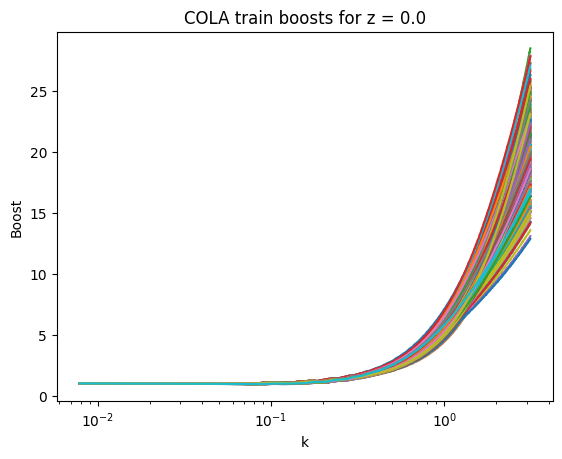

In [20]:
z_index = 0
for i in range(400):
    plt.semilogx(ks, np.exp(train_logboosts[i,z_index]))
plt.title(f"COLA train boosts for z = {redshifts[z_index]}")
plt.xlabel("k")
plt.ylabel("Boost");

In [62]:
# Normalized parameters - input for NN
train_sample_norm = np.zeros((len(train_samples), len(train_samples[0])))
for i, train_point in enumerate(train_samples):
    train_sample_norm[i] = utils.normalize_params(train_point)

In [63]:
# Normalized Boosts with Min-Max
train_logboosts_norm = np.zeros((len(train_samples), len(redshifts), len(ks)))
train_qs_norm = np.zeros((len(train_samples), len(redshifts), len(ks)))
for i, z in enumerate(redshifts):
    if z < 2:
        train_logboosts_norm[:,i,:] = utils.normalize_array(train_logboosts[:,i,:]) # I normalize within each redshift
        train_qs_norm[:,i,:] = utils.normalize_array(train_qs[:,i,:]) # I normalize within each redshift
    else:
        train_qs_norm[:,i,:256] = utils.normalize_array(train_qs[:,i,:256]) # I normalize within each redshift

In [102]:
# Getting and saving min and max for rescaling
mins_logboosts = np.zeros(len(redshifts))
maxs_logboosts = np.zeros(len(redshifts))
mins_qs = np.zeros(len(redshifts))
maxs_qs = np.zeros(len(redshifts))

for i, z in enumerate(redshifts):
    if z < 2:
        mins_logboosts[i] = np.amin(train_logboosts[:,i,:])
        maxs_logboosts[i] = np.amax(train_logboosts[:,i,:])
        mins_qs[i] = np.amin(train_qs[:,i,:])
        maxs_qs[i] = np.amax(train_qs[:,i,:])
    else:
        mins_logboosts[i] = np.amin(train_logboosts[:,i,:256])
        maxs_logboosts[i] = np.amax(train_logboosts[:,i,:256])
        mins_qs[i] = np.amin(train_qs[:,i,:256])
        maxs_qs[i] = np.amax(train_qs[:,i,:256])
np.savetxt("./mins.txt", mins_qs)
np.savetxt("./maxs.txt", maxs_qs)

In [98]:
# PCA reduction
num_pcs = 11
pcas_qs_before_z2, train_qs_pcs = utils.pca_reduction(num_pcs, train_qs_norm, redshifts[:34])

In [99]:
# Cutting scales for z >= 2
train_qs_norm_cut = train_qs_norm[:,:,:256]
pcas_qs_after_z2, train_qs_pcs = utils.pca_reduction(num_pcs, train_qs_norm_cut, redshifts)
pcas_qs_after_z2 = pcas_qs_after_z2[34:]
pcas_qs = pcas_qs_before_z2 + pcas_qs_after_z2

In [104]:
dir(pcas_qs[0])

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_n_features',
 '_fit',
 '_fit_full',
 '_fit_svd_solver',
 '_fit_truncated',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_n_features_out',
 '_parameter_constraints',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_sklearn_auto_wrap_output_keys',
 '_validate_data',
 '_validate_params',
 'components_',
 'copy',
 'explained_variance_',
 'explained_variance_ratio_',
 'fit',
 'fit_transform',
 'get_covariance',
 'get_feature_names_out',
 'get_params',
 'get_precision',
 'inverse_trans

In [113]:
# inv_transform = mean + \sum_i pc_i * component_i
np.shape(pcas_qs[34].components_)
#for i in range(len(redshifts)):
#    np.savetxt(f"data/pc_basis/pcs_{i}.txt", pcas_qs[i].components_)

(11, 256)

### Training
**How to use**: 
- **Must have run [data preprocessing](#Data-preprocessing) section with the desired dataset**
- Define your model using the `utils.generate_resnet` or `utils.generate_mlp` functions.
- Train the model using the `utils.nn_model_train` function, where you can choose to train on `logboosts` or smeared boosts.
- Save your model using `model.save("path")`.
- See cells below for examples on training individual models at $z = 0$ and how to sequentially train models on all redshifts.

In [51]:
# Generate MLP model
mlp = utils.generate_mlp(
    input_shape=len(train_samples[0]),
    output_shape=num_pcs,
    num_layers=3,
    num_neurons=512,
    activation="custom",
    alpha=0,
    l1_ratio=0.1,
    loss='mse',
    learning_rate=1e-3,
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense (Dense)               (None, 512)               3072      
                                                                 
 custom_activation_layer (Cu  (None, 512)              1024      
 stomActivationLayer)                                            
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 custom_activation_layer_1 (  (None, 512)              1024      
 CustomActivationLayer)                                          
                                                                 
 dense_2 (Dense)             (None, 512)               262656

In [16]:
# Generate resnet model
resnet = utils.generate_resnet(
    input_shape=len(train_samples[0]),
    output_shape=num_pcs,
    num_res_blocks=1,
    num_of_neurons=1024,
    activation="relu",
    alpha=0,
    l1_ratio=0.1,
    dropout=0
)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 dense_4 (Dense)                (None, 1024)         6144        ['input_2[0][0]']                
                                                                                                  
 custom_activation_layer_3 (Cus  (None, 1024)        2048        ['dense_4[0][0]']                
 tomActivationLayer)                                                                              
                                                                                                  
 dense_5 (Dense)                (None, 1024)         1049600     ['custom_activation_layer_3

In [52]:
# Training (z=0) for 2.6k epochs. Starting from epoch 1500, the learning rate halves every 200 epochs
start = perf_counter()
last_loss = utils.nn_model_train(mlp, 1600, train_sample_norm, train_qs_pcs[:,0], decayevery=1500, decayrate=2)
last_loss = utils.nn_model_train(mlp, 1000, train_sample_norm, train_qs_pcs[:,0], decayevery=200, decayrate=2)
print(f"Training took {perf_counter() - start} seconds")

Epoch 1/1600
14/14 [==============================] - 1s 6ms/step - loss: 0.0262 - lr: 0.0010
Epoch 2/1600
14/14 [==============================] - 0s 6ms/step - loss: 0.0099 - lr: 0.0010
Epoch 3/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0061 - lr: 0.0010
Epoch 4/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0048 - lr: 0.0010
Epoch 5/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0042 - lr: 0.0010
Epoch 6/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0042 - lr: 0.0010
Epoch 7/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0044 - lr: 0.0010
Epoch 8/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0045 - lr: 0.0010
Epoch 9/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0044 - lr: 0.0010
Epoch 10/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0045 - lr: 0.0010
Epoch 11/1600
14/14 [==============================] - 0s 5

Epoch 86/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.9676e-04 - lr: 0.0010
Epoch 87/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.9062e-04 - lr: 0.0010
Epoch 88/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.1656e-04 - lr: 0.0010
Epoch 89/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.6686e-04 - lr: 0.0010
Epoch 90/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.8846e-04 - lr: 0.0010
Epoch 91/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.0639e-04 - lr: 0.0010
Epoch 92/1600
14/14 [==============================] - 0s 4ms/step - loss: 1.6259e-04 - lr: 0.0010
Epoch 93/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.4420e-04 - lr: 0.0010
Epoch 94/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.3916e-04 - lr: 0.0010
Epoch 95/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.4745e-04 - lr: 0.0010
Epoch 96/1

14/14 [==============================] - 0s 5ms/step - loss: 4.9974e-05 - lr: 0.0010
Epoch 169/1600
14/14 [==============================] - 0s 4ms/step - loss: 6.7060e-05 - lr: 0.0010
Epoch 170/1600
14/14 [==============================] - 0s 4ms/step - loss: 6.6538e-05 - lr: 0.0010
Epoch 171/1600
14/14 [==============================] - 0s 5ms/step - loss: 5.4236e-05 - lr: 0.0010
Epoch 172/1600
14/14 [==============================] - 0s 5ms/step - loss: 4.3298e-05 - lr: 0.0010
Epoch 173/1600
14/14 [==============================] - 0s 4ms/step - loss: 4.4220e-05 - lr: 0.0010
Epoch 174/1600
14/14 [==============================] - 0s 5ms/step - loss: 3.7968e-05 - lr: 0.0010
Epoch 175/1600
14/14 [==============================] - 0s 7ms/step - loss: 3.5783e-05 - lr: 0.0010
Epoch 176/1600
14/14 [==============================] - 0s 6ms/step - loss: 4.6648e-05 - lr: 0.0010
Epoch 177/1600
14/14 [==============================] - 0s 5ms/step - loss: 3.9561e-05 - lr: 0.0010
Epoch 178/1600


14/14 [==============================] - 0s 5ms/step - loss: 1.8160e-05 - lr: 0.0010
Epoch 251/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.1217e-05 - lr: 0.0010
Epoch 252/1600
14/14 [==============================] - 0s 4ms/step - loss: 2.0821e-05 - lr: 0.0010
Epoch 253/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.4192e-05 - lr: 0.0010
Epoch 254/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.7522e-05 - lr: 0.0010
Epoch 255/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.3662e-05 - lr: 0.0010
Epoch 256/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.1092e-05 - lr: 0.0010
Epoch 257/1600
14/14 [==============================] - 0s 5ms/step - loss: 4.2251e-05 - lr: 0.0010
Epoch 258/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.1745e-05 - lr: 0.0010
Epoch 259/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.7072e-05 - lr: 0.0010
Epoch 260/1600


14/14 [==============================] - 0s 5ms/step - loss: 1.4610e-05 - lr: 0.0010
Epoch 333/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.1087e-05 - lr: 0.0010
Epoch 334/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.0972e-05 - lr: 0.0010
Epoch 335/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.3011e-05 - lr: 0.0010
Epoch 336/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.3205e-05 - lr: 0.0010
Epoch 337/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.7854e-05 - lr: 0.0010
Epoch 338/1600
14/14 [==============================] - 0s 5ms/step - loss: 8.6356e-05 - lr: 0.0010
Epoch 339/1600
14/14 [==============================] - 0s 5ms/step - loss: 5.9738e-05 - lr: 0.0010
Epoch 340/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.7845e-05 - lr: 0.0010
Epoch 341/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.9256e-05 - lr: 0.0010
Epoch 342/1600


14/14 [==============================] - 0s 5ms/step - loss: 5.6149e-05 - lr: 0.0010
Epoch 415/1600
14/14 [==============================] - 0s 5ms/step - loss: 3.8080e-05 - lr: 0.0010
Epoch 416/1600
14/14 [==============================] - 0s 5ms/step - loss: 4.8366e-05 - lr: 0.0010
Epoch 417/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.7232e-05 - lr: 0.0010
Epoch 418/1600
14/14 [==============================] - 0s 5ms/step - loss: 4.5502e-05 - lr: 0.0010
Epoch 419/1600
14/14 [==============================] - 0s 5ms/step - loss: 3.6671e-05 - lr: 0.0010
Epoch 420/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.4762e-05 - lr: 0.0010
Epoch 421/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.2099e-05 - lr: 0.0010
Epoch 422/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.3069e-05 - lr: 0.0010
Epoch 423/1600
14/14 [==============================] - 0s 5ms/step - loss: 9.7226e-06 - lr: 0.0010
Epoch 424/1600


14/14 [==============================] - 0s 5ms/step - loss: 1.0775e-05 - lr: 0.0010
Epoch 497/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.3628e-05 - lr: 0.0010
Epoch 498/1600
14/14 [==============================] - 0s 5ms/step - loss: 3.3313e-05 - lr: 0.0010
Epoch 499/1600
14/14 [==============================] - 0s 6ms/step - loss: 1.4327e-04 - lr: 0.0010
Epoch 500/1600
14/14 [==============================] - 0s 5ms/step - loss: 7.1077e-05 - lr: 0.0010
Epoch 501/1600
14/14 [==============================] - 0s 3ms/step - loss: 3.1417e-05 - lr: 0.0010
Epoch 502/1600
14/14 [==============================] - 0s 3ms/step - loss: 1.4253e-05 - lr: 0.0010
Epoch 503/1600
14/14 [==============================] - 0s 3ms/step - loss: 2.3238e-05 - lr: 0.0010
Epoch 504/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.9862e-05 - lr: 0.0010
Epoch 505/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.5542e-05 - lr: 0.0010
Epoch 506/1600


14/14 [==============================] - 0s 5ms/step - loss: 1.3944e-05 - lr: 0.0010
Epoch 579/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.9915e-05 - lr: 0.0010
Epoch 580/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.4707e-05 - lr: 0.0010
Epoch 581/1600
14/14 [==============================] - 0s 6ms/step - loss: 1.2539e-05 - lr: 0.0010
Epoch 582/1600
14/14 [==============================] - 0s 5ms/step - loss: 9.1671e-06 - lr: 0.0010
Epoch 583/1600
14/14 [==============================] - 0s 5ms/step - loss: 8.0366e-06 - lr: 0.0010
Epoch 584/1600
14/14 [==============================] - 0s 5ms/step - loss: 5.2382e-06 - lr: 0.0010
Epoch 585/1600
14/14 [==============================] - 0s 5ms/step - loss: 7.0316e-06 - lr: 0.0010
Epoch 586/1600
14/14 [==============================] - 0s 5ms/step - loss: 7.0686e-06 - lr: 0.0010
Epoch 587/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.0423e-05 - lr: 0.0010
Epoch 588/1600


14/14 [==============================] - 0s 5ms/step - loss: 1.0476e-05 - lr: 0.0010
Epoch 661/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.6659e-05 - lr: 0.0010
Epoch 662/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.7769e-05 - lr: 0.0010
Epoch 663/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.4978e-05 - lr: 0.0010
Epoch 664/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.3835e-05 - lr: 0.0010
Epoch 665/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.6592e-05 - lr: 0.0010
Epoch 666/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.7180e-05 - lr: 0.0010
Epoch 667/1600
14/14 [==============================] - 0s 5ms/step - loss: 9.6108e-06 - lr: 0.0010
Epoch 668/1600
14/14 [==============================] - 0s 5ms/step - loss: 9.5575e-06 - lr: 0.0010
Epoch 669/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.3466e-05 - lr: 0.0010
Epoch 670/1600


14/14 [==============================] - 0s 5ms/step - loss: 6.6898e-05 - lr: 0.0010
Epoch 743/1600
14/14 [==============================] - 0s 5ms/step - loss: 7.8431e-05 - lr: 0.0010
Epoch 744/1600
14/14 [==============================] - 0s 5ms/step - loss: 5.0516e-05 - lr: 0.0010
Epoch 745/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.8084e-05 - lr: 0.0010
Epoch 746/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.7679e-05 - lr: 0.0010
Epoch 747/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.2700e-05 - lr: 0.0010
Epoch 748/1600
14/14 [==============================] - 0s 5ms/step - loss: 9.1225e-06 - lr: 0.0010
Epoch 749/1600
14/14 [==============================] - 0s 5ms/step - loss: 8.5875e-06 - lr: 0.0010
Epoch 750/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.0041e-05 - lr: 0.0010
Epoch 751/1600
14/14 [==============================] - 0s 6ms/step - loss: 1.5791e-05 - lr: 0.0010
Epoch 752/1600


14/14 [==============================] - 0s 5ms/step - loss: 1.5115e-04 - lr: 0.0010
Epoch 825/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.0157e-04 - lr: 0.0010
Epoch 826/1600
14/14 [==============================] - 0s 5ms/step - loss: 3.4923e-05 - lr: 0.0010
Epoch 827/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.2992e-05 - lr: 0.0010
Epoch 828/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.4221e-05 - lr: 0.0010
Epoch 829/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.6232e-05 - lr: 0.0010
Epoch 830/1600
14/14 [==============================] - 0s 4ms/step - loss: 1.2247e-05 - lr: 0.0010
Epoch 831/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.3030e-05 - lr: 0.0010
Epoch 832/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.6970e-05 - lr: 0.0010
Epoch 833/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.0105e-05 - lr: 0.0010
Epoch 834/1600


14/14 [==============================] - 0s 5ms/step - loss: 8.6997e-06 - lr: 0.0010
Epoch 907/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.0552e-05 - lr: 0.0010
Epoch 908/1600
14/14 [==============================] - 0s 5ms/step - loss: 3.3109e-05 - lr: 0.0010
Epoch 909/1600
14/14 [==============================] - 0s 5ms/step - loss: 7.3307e-05 - lr: 0.0010
Epoch 910/1600
14/14 [==============================] - 0s 5ms/step - loss: 3.7847e-05 - lr: 0.0010
Epoch 911/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.7746e-05 - lr: 0.0010
Epoch 912/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.4205e-05 - lr: 0.0010
Epoch 913/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.0398e-05 - lr: 0.0010
Epoch 914/1600
14/14 [==============================] - 0s 5ms/step - loss: 8.2948e-06 - lr: 0.0010
Epoch 915/1600
14/14 [==============================] - 0s 5ms/step - loss: 6.3448e-06 - lr: 0.0010
Epoch 916/1600


14/14 [==============================] - 0s 5ms/step - loss: 1.0309e-05 - lr: 0.0010
Epoch 989/1600
14/14 [==============================] - 0s 5ms/step - loss: 5.5785e-06 - lr: 0.0010
Epoch 990/1600
14/14 [==============================] - 0s 5ms/step - loss: 5.7946e-06 - lr: 0.0010
Epoch 991/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.0580e-05 - lr: 0.0010
Epoch 992/1600
14/14 [==============================] - 0s 5ms/step - loss: 9.1895e-06 - lr: 0.0010
Epoch 993/1600
14/14 [==============================] - 0s 5ms/step - loss: 4.9880e-06 - lr: 0.0010
Epoch 994/1600
14/14 [==============================] - 0s 5ms/step - loss: 7.3072e-06 - lr: 0.0010
Epoch 995/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.3460e-05 - lr: 0.0010
Epoch 996/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.7790e-05 - lr: 0.0010
Epoch 997/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.2937e-05 - lr: 0.0010
Epoch 998/1600


14/14 [==============================] - 0s 5ms/step - loss: 1.5155e-05 - lr: 0.0010
Epoch 1151/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.9665e-05 - lr: 0.0010
Epoch 1152/1600
14/14 [==============================] - 0s 5ms/step - loss: 4.5370e-05 - lr: 0.0010
Epoch 1153/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.1769e-05 - lr: 0.0010
Epoch 1154/1600
14/14 [==============================] - 0s 5ms/step - loss: 8.9986e-06 - lr: 0.0010
Epoch 1155/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.2400e-05 - lr: 0.0010
Epoch 1156/1600
14/14 [==============================] - 0s 5ms/step - loss: 8.9192e-06 - lr: 0.0010
Epoch 1157/1600
14/14 [==============================] - 0s 5ms/step - loss: 5.5103e-06 - lr: 0.0010
Epoch 1158/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.6910e-05 - lr: 0.0010
Epoch 1159/1600
14/14 [==============================] - 0s 5ms/step - loss: 9.7146e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 8.9035e-06 - lr: 0.0010
Epoch 1313/1600
14/14 [==============================] - 0s 5ms/step - loss: 7.5104e-06 - lr: 0.0010
Epoch 1314/1600
14/14 [==============================] - 0s 5ms/step - loss: 4.5215e-06 - lr: 0.0010
Epoch 1315/1600
14/14 [==============================] - 0s 5ms/step - loss: 5.6864e-06 - lr: 0.0010
Epoch 1316/1600
14/14 [==============================] - 0s 5ms/step - loss: 5.0683e-06 - lr: 0.0010
Epoch 1317/1600
14/14 [==============================] - 0s 5ms/step - loss: 7.0355e-06 - lr: 0.0010
Epoch 1318/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.1849e-05 - lr: 0.0010
Epoch 1319/1600
14/14 [==============================] - 0s 5ms/step - loss: 7.5020e-06 - lr: 0.0010
Epoch 1320/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.0275e-05 - lr: 0.0010
Epoch 1321/1600
14/14 [==============================] - 0s 5ms/step - loss: 6.1576e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 8.2183e-06 - lr: 0.0010
Epoch 1475/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.8082e-05 - lr: 0.0010
Epoch 1476/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.1941e-05 - lr: 0.0010
Epoch 1477/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.0460e-05 - lr: 0.0010
Epoch 1478/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.9784e-05 - lr: 0.0010
Epoch 1479/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.6908e-05 - lr: 0.0010
Epoch 1480/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.6609e-05 - lr: 0.0010
Epoch 1481/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.6716e-05 - lr: 0.0010
Epoch 1482/1600
14/14 [==============================] - 0s 5ms/step - loss: 7.4024e-06 - lr: 0.0010
Epoch 1483/1600
14/14 [==============================] - 0s 5ms/step - loss: 5.5606e-06 - lr: 0.0010
Epoch 

Epoch 32/1000
14/14 [==============================] - 0s 3ms/step - loss: 3.1606e-06 - lr: 5.0000e-04
Epoch 33/1000
14/14 [==============================] - 0s 3ms/step - loss: 4.2328e-06 - lr: 5.0000e-04
Epoch 34/1000
14/14 [==============================] - 0s 3ms/step - loss: 3.7396e-06 - lr: 5.0000e-04
Epoch 35/1000
14/14 [==============================] - 0s 3ms/step - loss: 2.8366e-06 - lr: 5.0000e-04
Epoch 36/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.4075e-06 - lr: 5.0000e-04
Epoch 37/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.0355e-06 - lr: 5.0000e-04
Epoch 38/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.3004e-06 - lr: 5.0000e-04
Epoch 39/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6099e-06 - lr: 5.0000e-04
Epoch 40/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.8675e-06 - lr: 5.0000e-04
Epoch 41/1000
14/14 [==============================] - 0s 5ms/step - loss

Epoch 190/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.9757e-06 - lr: 5.0000e-04
Epoch 191/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.8810e-06 - lr: 5.0000e-04
Epoch 192/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.6777e-06 - lr: 5.0000e-04
Epoch 193/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.0286e-06 - lr: 5.0000e-04
Epoch 194/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.8966e-06 - lr: 5.0000e-04
Epoch 195/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.4543e-06 - lr: 5.0000e-04
Epoch 196/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8436e-06 - lr: 5.0000e-04
Epoch 197/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.0918e-06 - lr: 5.0000e-04
Epoch 198/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.9630e-06 - lr: 5.0000e-04
Epoch 199/1000
14/14 [==============================] - 0s 5ms/s

Epoch 347/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.1725e-06 - lr: 2.5000e-04
Epoch 348/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.1770e-06 - lr: 2.5000e-04
Epoch 349/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.1762e-06 - lr: 2.5000e-04
Epoch 350/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.8347e-06 - lr: 2.5000e-04
Epoch 351/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0694e-06 - lr: 2.5000e-04
Epoch 352/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.4422e-06 - lr: 2.5000e-04
Epoch 353/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.4666e-06 - lr: 2.5000e-04
Epoch 354/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0618e-06 - lr: 2.5000e-04
Epoch 355/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.9657e-06 - lr: 2.5000e-04
Epoch 356/1000
14/14 [==============================] - 0s 5ms/s

Epoch 504/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.8715e-06 - lr: 1.2500e-04
Epoch 505/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7313e-06 - lr: 1.2500e-04
Epoch 506/1000
14/14 [==============================] - 0s 4ms/step - loss: 1.6211e-06 - lr: 1.2500e-04
Epoch 507/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6776e-06 - lr: 1.2500e-04
Epoch 508/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6461e-06 - lr: 1.2500e-04
Epoch 509/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6879e-06 - lr: 1.2500e-04
Epoch 510/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.1367e-06 - lr: 1.2500e-04
Epoch 511/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0185e-06 - lr: 1.2500e-04
Epoch 512/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7824e-06 - lr: 1.2500e-04
Epoch 513/1000
14/14 [==============================] - 0s 5ms/s

Epoch 661/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5203e-06 - lr: 6.2500e-05
Epoch 662/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5707e-06 - lr: 6.2500e-05
Epoch 663/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5724e-06 - lr: 6.2500e-05
Epoch 664/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7104e-06 - lr: 6.2500e-05
Epoch 665/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0433e-06 - lr: 6.2500e-05
Epoch 666/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5668e-06 - lr: 6.2500e-05
Epoch 667/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7579e-06 - lr: 6.2500e-05
Epoch 668/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6366e-06 - lr: 6.2500e-05
Epoch 669/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7445e-06 - lr: 6.2500e-05
Epoch 670/1000
14/14 [==============================] - 0s 5ms/s

Epoch 818/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4234e-06 - lr: 3.1250e-05
Epoch 819/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4807e-06 - lr: 3.1250e-05
Epoch 820/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3906e-06 - lr: 3.1250e-05
Epoch 821/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4228e-06 - lr: 3.1250e-05
Epoch 822/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4090e-06 - lr: 3.1250e-05
Epoch 823/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4293e-06 - lr: 3.1250e-05
Epoch 824/1000
14/14 [==============================] - 0s 4ms/step - loss: 1.4582e-06 - lr: 3.1250e-05
Epoch 825/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4194e-06 - lr: 3.1250e-05
Epoch 826/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4252e-06 - lr: 3.1250e-05
Epoch 827/1000
14/14 [==============================] - 0s 5ms/s

Epoch 975/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4862e-06 - lr: 3.1250e-05
Epoch 976/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4192e-06 - lr: 3.1250e-05
Epoch 977/1000
14/14 [==============================] - 0s 4ms/step - loss: 1.4499e-06 - lr: 3.1250e-05
Epoch 978/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4626e-06 - lr: 3.1250e-05
Epoch 979/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4682e-06 - lr: 3.1250e-05
Epoch 980/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4870e-06 - lr: 3.1250e-05
Epoch 981/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3994e-06 - lr: 3.1250e-05
Epoch 982/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4442e-06 - lr: 3.1250e-05
Epoch 983/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5437e-06 - lr: 3.1250e-05
Epoch 984/1000
14/14 [==============================] - 0s 5ms/s

In [16]:
mlp.save("./models/LCDM/NN_z0.000")

INFO:tensorflow:Assets written to: models/lcdm/customactivation/assets


INFO:tensorflow:Assets written to: models/lcdm/customactivation/assets


In [48]:
# Automatically generate and save models for each redshift
for i, z in enumerate(redshifts):
    if z <= 2:
        print(f"Already trained model for z = {z}. Skipping...")
        continue
    
    mlp = utils.generate_mlp(
        input_shape=len(train_samples[0]),
        output_shape=num_pcs,
        num_layers=3,
        num_neurons=512,
        activation="custom",
        alpha=0,
        l1_ratio=0.1,
        loss='mse',
        learning_rate=1e-3,
    )
    
    print(f"Starting training for redshift {z:.3f}")
    start = perf_counter()
    # Notice that i'm passing the PCs for redshift i to the training
    truths = train_qs_pcs[:,i]
    
    last_loss = utils.nn_model_train(mlp, 1500, train_sample_norm, truths, decayevery=1400, decayrate=2)
    last_loss = utils.nn_model_train(mlp, 1000, train_sample_norm, truths, decayevery=200, decayrate=10)
    print(f"Training for redshift {z:.2f} took {perf_counter() - start} seconds")
    
    mlp.save(f"models/LCDM/NN_Z{z:.3f}")

Already trained model for z = 0.0. Skipping...
Already trained model for z = 0.02. Skipping...
Already trained model for z = 0.041. Skipping...
Already trained model for z = 0.062. Skipping...
Already trained model for z = 0.085. Skipping...
Already trained model for z = 0.109. Skipping...
Already trained model for z = 0.133. Skipping...
Already trained model for z = 0.159. Skipping...
Already trained model for z = 0.186. Skipping...
Already trained model for z = 0.214. Skipping...
Already trained model for z = 0.244. Skipping...
Already trained model for z = 0.275. Skipping...
Already trained model for z = 0.308. Skipping...
Already trained model for z = 0.342. Skipping...
Already trained model for z = 0.378. Skipping...
Already trained model for z = 0.417. Skipping...
Already trained model for z = 0.457. Skipping...
Already trained model for z = 0.5. Skipping...
Already trained model for z = 0.543. Skipping...
Already trained model for z = 0.588. Skipping...
Already trained model for

Epoch 51/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6899e-04 - lr: 0.0010
Epoch 52/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.3569e-04 - lr: 0.0010
Epoch 53/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.0537e-04 - lr: 0.0010
Epoch 54/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8044e-04 - lr: 0.0010
Epoch 55/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9317e-04 - lr: 0.0010
Epoch 56/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.6792e-04 - lr: 0.0010
Epoch 57/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1126e-04 - lr: 0.0010
Epoch 58/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5739e-04 - lr: 0.0010
Epoch 59/1500
14/14 [==============================] - 0s 6ms/step - loss: 2.4659e-04 - lr: 0.0010
Epoch 60/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4786e-04 - lr: 0.0010
Epoch 61/1

14/14 [==============================] - 0s 5ms/step - loss: 2.2900e-04 - lr: 0.0010
Epoch 134/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8926e-04 - lr: 0.0010
Epoch 135/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9693e-04 - lr: 0.0010
Epoch 136/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.6484e-04 - lr: 0.0010
Epoch 137/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3862e-04 - lr: 0.0010
Epoch 138/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0157e-04 - lr: 0.0010
Epoch 139/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7838e-04 - lr: 0.0010
Epoch 140/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8718e-04 - lr: 0.0010
Epoch 141/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8423e-04 - lr: 0.0010
Epoch 142/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0650e-04 - lr: 0.0010
Epoch 143/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.4840e-04 - lr: 0.0010
Epoch 216/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9407e-04 - lr: 0.0010
Epoch 217/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2196e-04 - lr: 0.0010
Epoch 218/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1420e-04 - lr: 0.0010
Epoch 219/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3940e-04 - lr: 0.0010
Epoch 220/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1028e-04 - lr: 0.0010
Epoch 221/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9665e-04 - lr: 0.0010
Epoch 222/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1405e-04 - lr: 0.0010
Epoch 223/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1562e-04 - lr: 0.0010
Epoch 224/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.9101e-05 - lr: 0.0010
Epoch 225/1500


14/14 [==============================] - 0s 5ms/step - loss: 5.9609e-05 - lr: 0.0010
Epoch 298/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.7701e-05 - lr: 0.0010
Epoch 299/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.3736e-05 - lr: 0.0010
Epoch 300/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.8347e-05 - lr: 0.0010
Epoch 301/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.4470e-05 - lr: 0.0010
Epoch 302/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.2628e-05 - lr: 0.0010
Epoch 303/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.4460e-05 - lr: 0.0010
Epoch 304/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.2296e-05 - lr: 0.0010
Epoch 305/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.0515e-05 - lr: 0.0010
Epoch 306/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8926e-05 - lr: 0.0010
Epoch 307/1500


14/14 [==============================] - 0s 5ms/step - loss: 3.8252e-05 - lr: 0.0010
Epoch 380/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.5691e-05 - lr: 0.0010
Epoch 381/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.6045e-05 - lr: 0.0010
Epoch 382/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.0971e-05 - lr: 0.0010
Epoch 383/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.8418e-05 - lr: 0.0010
Epoch 384/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.3757e-05 - lr: 0.0010
Epoch 385/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.1715e-05 - lr: 0.0010
Epoch 386/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.9068e-05 - lr: 0.0010
Epoch 387/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.8171e-05 - lr: 0.0010
Epoch 388/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.2462e-05 - lr: 0.0010
Epoch 389/1500


14/14 [==============================] - 0s 5ms/step - loss: 5.8289e-05 - lr: 0.0010
Epoch 462/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.2494e-05 - lr: 0.0010
Epoch 463/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.0259e-05 - lr: 0.0010
Epoch 464/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2455e-05 - lr: 0.0010
Epoch 465/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5259e-05 - lr: 0.0010
Epoch 466/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3706e-05 - lr: 0.0010
Epoch 467/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8030e-05 - lr: 0.0010
Epoch 468/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3226e-05 - lr: 0.0010
Epoch 469/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.3076e-05 - lr: 0.0010
Epoch 470/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5092e-05 - lr: 0.0010
Epoch 471/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.3575e-05 - lr: 0.0010
Epoch 544/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6252e-05 - lr: 0.0010
Epoch 545/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1085e-05 - lr: 0.0010
Epoch 546/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0560e-05 - lr: 0.0010
Epoch 547/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8888e-05 - lr: 0.0010
Epoch 548/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.2705e-05 - lr: 0.0010
Epoch 549/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2972e-04 - lr: 0.0010
Epoch 550/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5679e-04 - lr: 0.0010
Epoch 551/1500
14/14 [==============================] - 0s 6ms/step - loss: 2.0106e-04 - lr: 0.0010
Epoch 552/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.5333e-05 - lr: 0.0010
Epoch 553/1500


14/14 [==============================] - 0s 7ms/step - loss: 1.8051e-05 - lr: 0.0010
Epoch 626/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4038e-05 - lr: 0.0010
Epoch 627/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5494e-05 - lr: 0.0010
Epoch 628/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5533e-05 - lr: 0.0010
Epoch 629/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2489e-05 - lr: 0.0010
Epoch 630/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8953e-05 - lr: 0.0010
Epoch 631/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0354e-05 - lr: 0.0010
Epoch 632/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1701e-05 - lr: 0.0010
Epoch 633/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1584e-05 - lr: 0.0010
Epoch 634/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.7435e-05 - lr: 0.0010
Epoch 635/1500


14/14 [==============================] - 0s 5ms/step - loss: 2.7293e-05 - lr: 0.0010
Epoch 708/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8703e-05 - lr: 0.0010
Epoch 709/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8248e-05 - lr: 0.0010
Epoch 710/1500
14/14 [==============================] - 0s 6ms/step - loss: 1.3147e-05 - lr: 0.0010
Epoch 711/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1383e-05 - lr: 0.0010
Epoch 712/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3607e-05 - lr: 0.0010
Epoch 713/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4378e-05 - lr: 0.0010
Epoch 714/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9572e-05 - lr: 0.0010
Epoch 715/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.1552e-05 - lr: 0.0010
Epoch 716/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.5903e-05 - lr: 0.0010
Epoch 717/1500


14/14 [==============================] - 0s 5ms/step - loss: 8.9261e-06 - lr: 0.0010
Epoch 790/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0650e-05 - lr: 0.0010
Epoch 791/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.1515e-06 - lr: 0.0010
Epoch 792/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.3882e-06 - lr: 0.0010
Epoch 793/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0724e-05 - lr: 0.0010
Epoch 794/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1992e-05 - lr: 0.0010
Epoch 795/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8559e-05 - lr: 0.0010
Epoch 796/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2303e-05 - lr: 0.0010
Epoch 797/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5542e-05 - lr: 0.0010
Epoch 798/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3991e-05 - lr: 0.0010
Epoch 799/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.0293e-05 - lr: 0.0010
Epoch 872/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0994e-05 - lr: 0.0010
Epoch 873/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5511e-05 - lr: 0.0010
Epoch 874/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2934e-05 - lr: 0.0010
Epoch 875/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3266e-05 - lr: 0.0010
Epoch 876/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5440e-05 - lr: 0.0010
Epoch 877/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4927e-05 - lr: 0.0010
Epoch 878/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1999e-05 - lr: 0.0010
Epoch 879/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8651e-05 - lr: 0.0010
Epoch 880/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8728e-05 - lr: 0.0010
Epoch 881/1500


14/14 [==============================] - 0s 5ms/step - loss: 9.5544e-06 - lr: 0.0010
Epoch 954/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.5224e-06 - lr: 0.0010
Epoch 955/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.5038e-06 - lr: 0.0010
Epoch 956/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.7702e-06 - lr: 0.0010
Epoch 957/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.6378e-06 - lr: 0.0010
Epoch 958/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.5505e-06 - lr: 0.0010
Epoch 959/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.2194e-06 - lr: 0.0010
Epoch 960/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0532e-05 - lr: 0.0010
Epoch 961/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6044e-05 - lr: 0.0010
Epoch 962/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0865e-05 - lr: 0.0010
Epoch 963/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.5302e-05 - lr: 0.0010
Epoch 1035/1500
14/14 [==============================] - 0s 6ms/step - loss: 9.9430e-06 - lr: 0.0010
Epoch 1036/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3820e-05 - lr: 0.0010
Epoch 1037/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5722e-05 - lr: 0.0010
Epoch 1038/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0993e-05 - lr: 0.0010
Epoch 1039/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3243e-05 - lr: 0.0010
Epoch 1040/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9403e-05 - lr: 0.0010
Epoch 1041/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8749e-05 - lr: 0.0010
Epoch 1042/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3634e-05 - lr: 0.0010
Epoch 1043/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5529e-05 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 1.2643e-05 - lr: 0.0010
Epoch 1116/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.3180e-06 - lr: 0.0010
Epoch 1117/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0122e-05 - lr: 0.0010
Epoch 1118/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.9403e-06 - lr: 0.0010
Epoch 1119/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.4513e-06 - lr: 0.0010
Epoch 1120/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1152e-05 - lr: 0.0010
Epoch 1121/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9754e-05 - lr: 0.0010
Epoch 1122/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.8802e-05 - lr: 0.0010
Epoch 1123/1500
14/14 [==============================] - 0s 4ms/step - loss: 6.5916e-05 - lr: 0.0010
Epoch 1124/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.5065e-05 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 5.6765e-05 - lr: 0.0010
Epoch 1197/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.0075e-05 - lr: 0.0010
Epoch 1198/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.3724e-05 - lr: 0.0010
Epoch 1199/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.1440e-05 - lr: 0.0010
Epoch 1200/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0754e-05 - lr: 0.0010
Epoch 1201/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2786e-05 - lr: 0.0010
Epoch 1202/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8938e-05 - lr: 0.0010
Epoch 1203/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.3267e-05 - lr: 0.0010
Epoch 1204/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9371e-05 - lr: 0.0010
Epoch 1205/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5172e-05 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 2.9267e-05 - lr: 0.0010
Epoch 1278/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1563e-05 - lr: 0.0010
Epoch 1279/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.6978e-06 - lr: 0.0010
Epoch 1280/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.3106e-06 - lr: 0.0010
Epoch 1281/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.5524e-06 - lr: 0.0010
Epoch 1282/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.5465e-06 - lr: 0.0010
Epoch 1283/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.5928e-06 - lr: 0.0010
Epoch 1284/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.9433e-06 - lr: 0.0010
Epoch 1285/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.6374e-06 - lr: 0.0010
Epoch 1286/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2826e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 2.0281e-05 - lr: 0.0010
Epoch 1359/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2392e-05 - lr: 0.0010
Epoch 1360/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5694e-05 - lr: 0.0010
Epoch 1361/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1120e-05 - lr: 0.0010
Epoch 1362/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.0348e-06 - lr: 0.0010
Epoch 1363/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.1774e-06 - lr: 0.0010
Epoch 1364/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.7325e-06 - lr: 0.0010
Epoch 1365/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8826e-06 - lr: 0.0010
Epoch 1366/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4775e-06 - lr: 0.0010
Epoch 1367/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.0062e-06 - lr: 0.0010
Epoch 

Epoch 1438/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.0783e-06 - lr: 5.0000e-04
Epoch 1439/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8819e-06 - lr: 5.0000e-04
Epoch 1440/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.6369e-06 - lr: 5.0000e-04
Epoch 1441/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.5156e-06 - lr: 5.0000e-04
Epoch 1442/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5604e-05 - lr: 5.0000e-04
Epoch 1443/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.5051e-06 - lr: 5.0000e-04
Epoch 1444/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.9437e-06 - lr: 5.0000e-04
Epoch 1445/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0281e-06 - lr: 5.0000e-04
Epoch 1446/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8814e-06 - lr: 5.0000e-04
Epoch 1447/1500
14/14 [==============================] 

14/14 [==============================] - 0s 6ms/step - loss: 3.0359e-06 - lr: 5.0000e-04
Epoch 17/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.9585e-06 - lr: 5.0000e-04
Epoch 18/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.6003e-06 - lr: 5.0000e-04
Epoch 19/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.5692e-06 - lr: 5.0000e-04
Epoch 20/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.8084e-06 - lr: 5.0000e-04
Epoch 21/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.8679e-06 - lr: 5.0000e-04
Epoch 22/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8083e-06 - lr: 5.0000e-04
Epoch 23/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.6037e-06 - lr: 5.0000e-04
Epoch 24/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0855e-06 - lr: 5.0000e-04
Epoch 25/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.1971e-06 -

14/14 [==============================] - 0s 5ms/step - loss: 1.5169e-05 - lr: 5.0000e-04
Epoch 96/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.1821e-06 - lr: 5.0000e-04
Epoch 97/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4446e-06 - lr: 5.0000e-04
Epoch 98/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.5290e-06 - lr: 5.0000e-04
Epoch 99/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.7235e-06 - lr: 5.0000e-04
Epoch 100/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.7298e-06 - lr: 5.0000e-04
Epoch 101/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.1230e-06 - lr: 5.0000e-04
Epoch 102/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.0702e-06 - lr: 5.0000e-04
Epoch 103/1000
14/14 [==============================] - 0s 7ms/step - loss: 2.8958e-06 - lr: 5.0000e-04
Epoch 104/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.6586e

Epoch 174/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.2807e-05 - lr: 5.0000e-04
Epoch 175/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.7646e-05 - lr: 5.0000e-04
Epoch 176/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6236e-04 - lr: 5.0000e-04
Epoch 177/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4477e-04 - lr: 5.0000e-04
Epoch 178/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.0623e-05 - lr: 5.0000e-04
Epoch 179/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.9482e-05 - lr: 5.0000e-04
Epoch 180/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.3547e-05 - lr: 5.0000e-04
Epoch 181/1000
14/14 [==============================] - 0s 7ms/step - loss: 1.2040e-05 - lr: 5.0000e-04
Epoch 182/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.7417e-06 - lr: 5.0000e-04
Epoch 183/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 1.0688e-06 - lr: 5.0000e-05
Epoch 253/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0703e-06 - lr: 5.0000e-05
Epoch 254/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0931e-06 - lr: 5.0000e-05
Epoch 255/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0815e-06 - lr: 5.0000e-05
Epoch 256/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0728e-06 - lr: 5.0000e-05
Epoch 257/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0444e-06 - lr: 5.0000e-05
Epoch 258/1000
14/14 [==============================] - 0s 4ms/step - loss: 1.1135e-06 - lr: 5.0000e-05
Epoch 259/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0771e-06 - lr: 5.0000e-05
Epoch 260/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0613e-06 - lr: 5.0000e-05
Epoch 261/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0

Epoch 331/1000
14/14 [==============================] - 0s 6ms/step - loss: 1.0612e-06 - lr: 5.0000e-05
Epoch 332/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1160e-06 - lr: 5.0000e-05
Epoch 333/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0876e-06 - lr: 5.0000e-05
Epoch 334/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1547e-06 - lr: 5.0000e-05
Epoch 335/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1348e-06 - lr: 5.0000e-05
Epoch 336/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0853e-06 - lr: 5.0000e-05
Epoch 337/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0230e-06 - lr: 5.0000e-05
Epoch 338/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0634e-06 - lr: 5.0000e-05
Epoch 339/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0484e-06 - lr: 5.0000e-05
Epoch 340/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 9.5159e-07 - lr: 5.0000e-06
Epoch 410/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.4772e-07 - lr: 5.0000e-06
Epoch 411/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.4933e-07 - lr: 5.0000e-06
Epoch 412/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.6680e-07 - lr: 5.0000e-06
Epoch 413/1000
14/14 [==============================] - 0s 4ms/step - loss: 9.6506e-07 - lr: 5.0000e-06
Epoch 414/1000
14/14 [==============================] - 0s 4ms/step - loss: 9.4404e-07 - lr: 5.0000e-06
Epoch 415/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.5257e-07 - lr: 5.0000e-06
Epoch 416/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.4528e-07 - lr: 5.0000e-06
Epoch 417/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.5977e-07 - lr: 5.0000e-06
Epoch 418/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.5

Epoch 488/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.4627e-07 - lr: 5.0000e-06
Epoch 489/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.6604e-07 - lr: 5.0000e-06
Epoch 490/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.7470e-07 - lr: 5.0000e-06
Epoch 491/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.4724e-07 - lr: 5.0000e-06
Epoch 492/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.5128e-07 - lr: 5.0000e-06
Epoch 493/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.5115e-07 - lr: 5.0000e-06
Epoch 494/1000
14/14 [==============================] - 0s 6ms/step - loss: 9.5557e-07 - lr: 5.0000e-06
Epoch 495/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.4947e-07 - lr: 5.0000e-06
Epoch 496/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.4885e-07 - lr: 5.0000e-06
Epoch 497/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 9.5219e-07 - lr: 5.0000e-06
Epoch 567/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.5196e-07 - lr: 5.0000e-06
Epoch 568/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.4738e-07 - lr: 5.0000e-06
Epoch 569/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.7134e-07 - lr: 5.0000e-06
Epoch 570/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.5149e-07 - lr: 5.0000e-06
Epoch 571/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.4991e-07 - lr: 5.0000e-06
Epoch 572/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.6832e-07 - lr: 5.0000e-06
Epoch 573/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.5517e-07 - lr: 5.0000e-06
Epoch 574/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.5117e-07 - lr: 5.0000e-06
Epoch 575/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.5

Epoch 645/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.3299e-07 - lr: 5.0000e-07
Epoch 646/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.3255e-07 - lr: 5.0000e-07
Epoch 647/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.3150e-07 - lr: 5.0000e-07
Epoch 648/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.3207e-07 - lr: 5.0000e-07
Epoch 649/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.3131e-07 - lr: 5.0000e-07
Epoch 650/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.3159e-07 - lr: 5.0000e-07
Epoch 651/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.3246e-07 - lr: 5.0000e-07
Epoch 652/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.3266e-07 - lr: 5.0000e-07
Epoch 653/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.3276e-07 - lr: 5.0000e-07
Epoch 654/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 9.3229e-07 - lr: 5.0000e-07
Epoch 724/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.3211e-07 - lr: 5.0000e-07
Epoch 725/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.3404e-07 - lr: 5.0000e-07
Epoch 726/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.3182e-07 - lr: 5.0000e-07
Epoch 727/1000
14/14 [==============================] - 0s 4ms/step - loss: 9.3224e-07 - lr: 5.0000e-07
Epoch 728/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.3217e-07 - lr: 5.0000e-07
Epoch 729/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.3257e-07 - lr: 5.0000e-07
Epoch 730/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.3198e-07 - lr: 5.0000e-07
Epoch 731/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.3278e-07 - lr: 5.0000e-07
Epoch 732/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.3

Epoch 802/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.2974e-07 - lr: 5.0000e-08
Epoch 803/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.2982e-07 - lr: 5.0000e-08
Epoch 804/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.2975e-07 - lr: 5.0000e-08
Epoch 805/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.2979e-07 - lr: 5.0000e-08
Epoch 806/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.2966e-07 - lr: 5.0000e-08
Epoch 807/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.2967e-07 - lr: 5.0000e-08
Epoch 808/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.2968e-07 - lr: 5.0000e-08
Epoch 809/1000
14/14 [==============================] - 0s 6ms/step - loss: 9.2977e-07 - lr: 5.0000e-08
Epoch 810/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.2983e-07 - lr: 5.0000e-08
Epoch 811/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 9.2960e-07 - lr: 5.0000e-08
Epoch 881/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.2960e-07 - lr: 5.0000e-08
Epoch 882/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.2980e-07 - lr: 5.0000e-08
Epoch 883/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.2967e-07 - lr: 5.0000e-08
Epoch 884/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.2976e-07 - lr: 5.0000e-08
Epoch 885/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.2959e-07 - lr: 5.0000e-08
Epoch 886/1000
14/14 [==============================] - 0s 4ms/step - loss: 9.2971e-07 - lr: 5.0000e-08
Epoch 887/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.2967e-07 - lr: 5.0000e-08
Epoch 888/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.2976e-07 - lr: 5.0000e-08
Epoch 889/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.2

Epoch 959/1000
14/14 [==============================] - 0s 4ms/step - loss: 9.2953e-07 - lr: 5.0000e-08
Epoch 960/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.2968e-07 - lr: 5.0000e-08
Epoch 961/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.2962e-07 - lr: 5.0000e-08
Epoch 962/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.2982e-07 - lr: 5.0000e-08
Epoch 963/1000
14/14 [==============================] - 0s 6ms/step - loss: 9.2967e-07 - lr: 5.0000e-08
Epoch 964/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.2963e-07 - lr: 5.0000e-08
Epoch 965/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.2975e-07 - lr: 5.0000e-08
Epoch 966/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.2954e-07 - lr: 5.0000e-08
Epoch 967/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.2960e-07 - lr: 5.0000e-08
Epoch 968/1000
14/14 [==============================] - 0s 5ms/s

INFO:tensorflow:Assets written to: models/LCDM/NN_Z2.158/assets


INFO:tensorflow:Assets written to: models/LCDM/NN_Z2.158/assets


Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_60 (Dense)            (None, 512)               3072      
                                                                 
 custom_activation_layer_45   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_61 (Dense)            (None, 512)               262656    
                                                                 
 custom_activation_layer_46   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_62 (Dense)            (None, 512)               262

14/14 [==============================] - 0s 5ms/step - loss: 2.9127e-04 - lr: 0.0010
Epoch 69/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2399e-04 - lr: 0.0010
Epoch 70/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2590e-04 - lr: 0.0010
Epoch 71/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.3663e-04 - lr: 0.0010
Epoch 72/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.2087e-04 - lr: 0.0010
Epoch 73/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.3046e-04 - lr: 0.0010
Epoch 74/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.8120e-04 - lr: 0.0010
Epoch 75/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.4932e-04 - lr: 0.0010
Epoch 76/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.9530e-04 - lr: 0.0010
Epoch 77/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2510e-04 - lr: 0.0010
Epoch 78/1500
14/14 [===

14/14 [==============================] - 0s 5ms/step - loss: 1.8977e-04 - lr: 0.0010
Epoch 151/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1915e-04 - lr: 0.0010
Epoch 152/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.0414e-04 - lr: 0.0010
Epoch 153/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.0135e-04 - lr: 0.0010
Epoch 154/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.5773e-04 - lr: 0.0010
Epoch 155/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0549e-04 - lr: 0.0010
Epoch 156/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8643e-04 - lr: 0.0010
Epoch 157/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9906e-04 - lr: 0.0010
Epoch 158/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9232e-04 - lr: 0.0010
Epoch 159/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8330e-04 - lr: 0.0010
Epoch 160/1500


14/14 [==============================] - 0s 5ms/step - loss: 9.3146e-05 - lr: 0.0010
Epoch 233/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.7109e-05 - lr: 0.0010
Epoch 234/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.7043e-05 - lr: 0.0010
Epoch 235/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.5636e-05 - lr: 0.0010
Epoch 236/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.4654e-05 - lr: 0.0010
Epoch 237/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.9262e-05 - lr: 0.0010
Epoch 238/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.3335e-05 - lr: 0.0010
Epoch 239/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0607e-04 - lr: 0.0010
Epoch 240/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1423e-04 - lr: 0.0010
Epoch 241/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2193e-04 - lr: 0.0010
Epoch 242/1500


14/14 [==============================] - 0s 5ms/step - loss: 7.7389e-05 - lr: 0.0010
Epoch 315/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4449e-04 - lr: 0.0010
Epoch 316/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1328e-04 - lr: 0.0010
Epoch 317/1500
14/14 [==============================] - 0s 4ms/step - loss: 1.2677e-04 - lr: 0.0010
Epoch 318/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0460e-04 - lr: 0.0010
Epoch 319/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.0987e-05 - lr: 0.0010
Epoch 320/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0635e-04 - lr: 0.0010
Epoch 321/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.5416e-05 - lr: 0.0010
Epoch 322/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.6596e-05 - lr: 0.0010
Epoch 323/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.6522e-05 - lr: 0.0010
Epoch 324/1500


14/14 [==============================] - 0s 5ms/step - loss: 6.8260e-05 - lr: 0.0010
Epoch 397/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.6610e-05 - lr: 0.0010
Epoch 398/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.3257e-05 - lr: 0.0010
Epoch 399/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1785e-04 - lr: 0.0010
Epoch 400/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9475e-04 - lr: 0.0010
Epoch 401/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.0728e-04 - lr: 0.0010
Epoch 402/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4575e-04 - lr: 0.0010
Epoch 403/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7156e-04 - lr: 0.0010
Epoch 404/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0023e-04 - lr: 0.0010
Epoch 405/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.2435e-05 - lr: 0.0010
Epoch 406/1500


14/14 [==============================] - 0s 5ms/step - loss: 3.7452e-05 - lr: 0.0010
Epoch 479/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.5670e-05 - lr: 0.0010
Epoch 480/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.5889e-05 - lr: 0.0010
Epoch 481/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.5206e-05 - lr: 0.0010
Epoch 482/1500
14/14 [==============================] - 0s 6ms/step - loss: 6.9433e-05 - lr: 0.0010
Epoch 483/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.3219e-05 - lr: 0.0010
Epoch 484/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.2978e-05 - lr: 0.0010
Epoch 485/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.7865e-05 - lr: 0.0010
Epoch 486/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1423e-05 - lr: 0.0010
Epoch 487/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1852e-05 - lr: 0.0010
Epoch 488/1500


14/14 [==============================] - 0s 5ms/step - loss: 2.1807e-05 - lr: 0.0010
Epoch 561/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9150e-05 - lr: 0.0010
Epoch 562/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1070e-05 - lr: 0.0010
Epoch 563/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0476e-05 - lr: 0.0010
Epoch 564/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6419e-05 - lr: 0.0010
Epoch 565/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1933e-04 - lr: 0.0010
Epoch 566/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.7109e-05 - lr: 0.0010
Epoch 567/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.9198e-05 - lr: 0.0010
Epoch 568/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8244e-04 - lr: 0.0010
Epoch 569/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0379e-04 - lr: 0.0010
Epoch 570/1500


14/14 [==============================] - 0s 5ms/step - loss: 2.1464e-05 - lr: 0.0010
Epoch 643/1500
14/14 [==============================] - 0s 6ms/step - loss: 3.5550e-05 - lr: 0.0010
Epoch 644/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7366e-05 - lr: 0.0010
Epoch 645/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.0246e-05 - lr: 0.0010
Epoch 646/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1329e-04 - lr: 0.0010
Epoch 647/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.6714e-05 - lr: 0.0010
Epoch 648/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.8632e-05 - lr: 0.0010
Epoch 649/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.7235e-05 - lr: 0.0010
Epoch 650/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.3832e-05 - lr: 0.0010
Epoch 651/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.6066e-05 - lr: 0.0010
Epoch 652/1500


14/14 [==============================] - 0s 6ms/step - loss: 6.5244e-05 - lr: 0.0010
Epoch 725/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5123e-05 - lr: 0.0010
Epoch 726/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9045e-05 - lr: 0.0010
Epoch 727/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6081e-05 - lr: 0.0010
Epoch 728/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6943e-05 - lr: 0.0010
Epoch 729/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3521e-05 - lr: 0.0010
Epoch 730/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.5418e-05 - lr: 0.0010
Epoch 731/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.3339e-05 - lr: 0.0010
Epoch 732/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.2378e-05 - lr: 0.0010
Epoch 733/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0058e-04 - lr: 0.0010
Epoch 734/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.5254e-05 - lr: 0.0010
Epoch 807/1500
14/14 [==============================] - 0s 7ms/step - loss: 1.0707e-05 - lr: 0.0010
Epoch 808/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9049e-05 - lr: 0.0010
Epoch 809/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.4655e-05 - lr: 0.0010
Epoch 810/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.0117e-05 - lr: 0.0010
Epoch 811/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.5051e-05 - lr: 0.0010
Epoch 812/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0458e-05 - lr: 0.0010
Epoch 813/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2330e-05 - lr: 0.0010
Epoch 814/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7666e-05 - lr: 0.0010
Epoch 815/1500
14/14 [==============================] - 0s 6ms/step - loss: 1.9026e-05 - lr: 0.0010
Epoch 816/1500


14/14 [==============================] - 0s 5ms/step - loss: 3.2421e-05 - lr: 0.0010
Epoch 889/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5432e-05 - lr: 0.0010
Epoch 890/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9505e-05 - lr: 0.0010
Epoch 891/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6971e-05 - lr: 0.0010
Epoch 892/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8944e-05 - lr: 0.0010
Epoch 893/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5073e-05 - lr: 0.0010
Epoch 894/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4633e-05 - lr: 0.0010
Epoch 895/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.7298e-06 - lr: 0.0010
Epoch 896/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.5163e-06 - lr: 0.0010
Epoch 897/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1194e-05 - lr: 0.0010
Epoch 898/1500


14/14 [==============================] - 0s 5ms/step - loss: 4.5790e-05 - lr: 0.0010
Epoch 971/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.3617e-05 - lr: 0.0010
Epoch 972/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1416e-05 - lr: 0.0010
Epoch 973/1500
14/14 [==============================] - 0s 4ms/step - loss: 4.6283e-05 - lr: 0.0010
Epoch 974/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.0596e-05 - lr: 0.0010
Epoch 975/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9891e-05 - lr: 0.0010
Epoch 976/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1170e-05 - lr: 0.0010
Epoch 977/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0232e-05 - lr: 0.0010
Epoch 978/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6261e-05 - lr: 0.0010
Epoch 979/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4898e-05 - lr: 0.0010
Epoch 980/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.3665e-05 - lr: 0.0010
Epoch 1052/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1336e-05 - lr: 0.0010
Epoch 1053/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0003e-05 - lr: 0.0010
Epoch 1054/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.2906e-06 - lr: 0.0010
Epoch 1055/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.0947e-06 - lr: 0.0010
Epoch 1056/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.3833e-06 - lr: 0.0010
Epoch 1057/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4440e-05 - lr: 0.0010
Epoch 1058/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1254e-05 - lr: 0.0010
Epoch 1059/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.4710e-06 - lr: 0.0010
Epoch 1060/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.5376e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 9.1514e-06 - lr: 0.0010
Epoch 1133/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.9963e-06 - lr: 0.0010
Epoch 1134/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.1143e-06 - lr: 0.0010
Epoch 1135/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0738e-05 - lr: 0.0010
Epoch 1136/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.0260e-06 - lr: 0.0010
Epoch 1137/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.2999e-06 - lr: 0.0010
Epoch 1138/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.4701e-06 - lr: 0.0010
Epoch 1139/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4742e-05 - lr: 0.0010
Epoch 1140/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0592e-05 - lr: 0.0010
Epoch 1141/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9720e-05 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 1.5461e-05 - lr: 0.0010
Epoch 1214/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6036e-05 - lr: 0.0010
Epoch 1215/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.0294e-05 - lr: 0.0010
Epoch 1216/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3278e-05 - lr: 0.0010
Epoch 1217/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1727e-05 - lr: 0.0010
Epoch 1218/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2370e-05 - lr: 0.0010
Epoch 1219/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0002e-05 - lr: 0.0010
Epoch 1220/1500
14/14 [==============================] - 0s 4ms/step - loss: 1.4408e-05 - lr: 0.0010
Epoch 1221/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7688e-05 - lr: 0.0010
Epoch 1222/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1877e-05 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 6.3517e-06 - lr: 0.0010
Epoch 1295/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.8863e-06 - lr: 0.0010
Epoch 1296/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1209e-05 - lr: 0.0010
Epoch 1297/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6384e-05 - lr: 0.0010
Epoch 1298/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1681e-05 - lr: 0.0010
Epoch 1299/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1706e-04 - lr: 0.0010
Epoch 1300/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9379e-04 - lr: 0.0010
Epoch 1301/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1605e-04 - lr: 0.0010
Epoch 1302/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5795e-04 - lr: 0.0010
Epoch 1303/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.2823e-05 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 1.2901e-05 - lr: 0.0010
Epoch 1376/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.4536e-06 - lr: 0.0010
Epoch 1377/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.5394e-06 - lr: 0.0010
Epoch 1378/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.7599e-06 - lr: 0.0010
Epoch 1379/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.2686e-06 - lr: 0.0010
Epoch 1380/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.7057e-06 - lr: 0.0010
Epoch 1381/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8310e-06 - lr: 0.0010
Epoch 1382/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.0163e-06 - lr: 0.0010
Epoch 1383/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.6177e-06 - lr: 0.0010
Epoch 1384/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.0980e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 2.8046e-06 - lr: 5.0000e-04
Epoch 1455/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2814e-06 - lr: 5.0000e-04
Epoch 1456/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5421e-06 - lr: 5.0000e-04
Epoch 1457/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7387e-06 - lr: 5.0000e-04
Epoch 1458/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.6146e-06 - lr: 5.0000e-04
Epoch 1459/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.7440e-06 - lr: 5.0000e-04
Epoch 1460/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.4021e-06 - lr: 5.0000e-04
Epoch 1461/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1583e-05 - lr: 5.0000e-04
Epoch 1462/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.8512e-06 - lr: 5.0000e-04
Epoch 1463/1500
14/14 [==============================] - 0s 5ms/step - 

Epoch 33/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8376e-06 - lr: 5.0000e-04
Epoch 34/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.6978e-06 - lr: 5.0000e-04
Epoch 35/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.3590e-06 - lr: 5.0000e-04
Epoch 36/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.2630e-06 - lr: 5.0000e-04
Epoch 37/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4626e-06 - lr: 5.0000e-04
Epoch 38/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.9354e-05 - lr: 5.0000e-04
Epoch 39/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4283e-05 - lr: 5.0000e-04
Epoch 40/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4797e-05 - lr: 5.0000e-04
Epoch 41/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0718e-05 - lr: 5.0000e-04
Epoch 42/1000
14/14 [==============================] - 0s 5ms/step - loss

14/14 [==============================] - 0s 5ms/step - loss: 1.3557e-05 - lr: 5.0000e-04
Epoch 113/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0487e-05 - lr: 5.0000e-04
Epoch 114/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.4614e-05 - lr: 5.0000e-04
Epoch 115/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2370e-05 - lr: 5.0000e-04
Epoch 116/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.0870e-06 - lr: 5.0000e-04
Epoch 117/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.3895e-06 - lr: 5.0000e-04
Epoch 118/1000
14/14 [==============================] - 0s 6ms/step - loss: 5.0226e-06 - lr: 5.0000e-04
Epoch 119/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.2532e-06 - lr: 5.0000e-04
Epoch 120/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8188e-06 - lr: 5.0000e-04
Epoch 121/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.6

Epoch 191/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6380e-06 - lr: 5.0000e-04
Epoch 192/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.9180e-06 - lr: 5.0000e-04
Epoch 193/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.2823e-06 - lr: 5.0000e-04
Epoch 194/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.2140e-06 - lr: 5.0000e-04
Epoch 195/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.8617e-06 - lr: 5.0000e-04
Epoch 196/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.3613e-06 - lr: 5.0000e-04
Epoch 197/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.5102e-06 - lr: 5.0000e-04
Epoch 198/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.9738e-06 - lr: 5.0000e-04
Epoch 199/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.1611e-06 - lr: 5.0000e-04
Epoch 200/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 9.9121e-07 - lr: 5.0000e-05
Epoch 270/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.6812e-07 - lr: 5.0000e-05
Epoch 271/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0041e-06 - lr: 5.0000e-05
Epoch 272/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0001e-06 - lr: 5.0000e-05
Epoch 273/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.5501e-07 - lr: 5.0000e-05
Epoch 274/1000
14/14 [==============================] - 0s 6ms/step - loss: 1.0458e-06 - lr: 5.0000e-05
Epoch 275/1000
14/14 [==============================] - 0s 6ms/step - loss: 9.5748e-07 - lr: 5.0000e-05
Epoch 276/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0233e-06 - lr: 5.0000e-05
Epoch 277/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0634e-06 - lr: 5.0000e-05
Epoch 278/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2

Epoch 348/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0157e-06 - lr: 5.0000e-05
Epoch 349/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0434e-06 - lr: 5.0000e-05
Epoch 350/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0329e-06 - lr: 5.0000e-05
Epoch 351/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9693e-07 - lr: 5.0000e-05
Epoch 352/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9921e-07 - lr: 5.0000e-05
Epoch 353/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0022e-06 - lr: 5.0000e-05
Epoch 354/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.5086e-07 - lr: 5.0000e-05
Epoch 355/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.8810e-07 - lr: 5.0000e-05
Epoch 356/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.8931e-07 - lr: 5.0000e-05
Epoch 357/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 8.7149e-07 - lr: 5.0000e-06
Epoch 427/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.6612e-07 - lr: 5.0000e-06
Epoch 428/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.6586e-07 - lr: 5.0000e-06
Epoch 429/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.7222e-07 - lr: 5.0000e-06
Epoch 430/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.7790e-07 - lr: 5.0000e-06
Epoch 431/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.6907e-07 - lr: 5.0000e-06
Epoch 432/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.6493e-07 - lr: 5.0000e-06
Epoch 433/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.8392e-07 - lr: 5.0000e-06
Epoch 434/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.6935e-07 - lr: 5.0000e-06
Epoch 435/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.8

Epoch 505/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.6988e-07 - lr: 5.0000e-06
Epoch 506/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.8226e-07 - lr: 5.0000e-06
Epoch 507/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.7524e-07 - lr: 5.0000e-06
Epoch 508/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.6575e-07 - lr: 5.0000e-06
Epoch 509/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.6818e-07 - lr: 5.0000e-06
Epoch 510/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.6823e-07 - lr: 5.0000e-06
Epoch 511/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.2754e-07 - lr: 5.0000e-06
Epoch 512/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.7960e-07 - lr: 5.0000e-06
Epoch 513/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.8501e-07 - lr: 5.0000e-06
Epoch 514/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 8.6821e-07 - lr: 5.0000e-06
Epoch 584/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.7328e-07 - lr: 5.0000e-06
Epoch 585/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.7717e-07 - lr: 5.0000e-06
Epoch 586/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.6170e-07 - lr: 5.0000e-06
Epoch 587/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.7125e-07 - lr: 5.0000e-06
Epoch 588/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.6616e-07 - lr: 5.0000e-06
Epoch 589/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.8880e-07 - lr: 5.0000e-06
Epoch 590/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.7777e-07 - lr: 5.0000e-06
Epoch 591/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.1386e-07 - lr: 5.0000e-06
Epoch 592/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.6

Epoch 662/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5026e-07 - lr: 5.0000e-07
Epoch 663/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5104e-07 - lr: 5.0000e-07
Epoch 664/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5214e-07 - lr: 5.0000e-07
Epoch 665/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4955e-07 - lr: 5.0000e-07
Epoch 666/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4938e-07 - lr: 5.0000e-07
Epoch 667/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5032e-07 - lr: 5.0000e-07
Epoch 668/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5038e-07 - lr: 5.0000e-07
Epoch 669/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5033e-07 - lr: 5.0000e-07
Epoch 670/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5039e-07 - lr: 5.0000e-07
Epoch 671/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 6ms/step - loss: 8.5030e-07 - lr: 5.0000e-07
Epoch 741/1000
14/14 [==============================] - 0s 4ms/step - loss: 8.4976e-07 - lr: 5.0000e-07
Epoch 742/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5044e-07 - lr: 5.0000e-07
Epoch 743/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5234e-07 - lr: 5.0000e-07
Epoch 744/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4912e-07 - lr: 5.0000e-07
Epoch 745/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4941e-07 - lr: 5.0000e-07
Epoch 746/1000
14/14 [==============================] - 0s 7ms/step - loss: 8.4956e-07 - lr: 5.0000e-07
Epoch 747/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5102e-07 - lr: 5.0000e-07
Epoch 748/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5299e-07 - lr: 5.0000e-07
Epoch 749/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4

Epoch 819/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4782e-07 - lr: 5.0000e-08
Epoch 820/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4754e-07 - lr: 5.0000e-08
Epoch 821/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4755e-07 - lr: 5.0000e-08
Epoch 822/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4760e-07 - lr: 5.0000e-08
Epoch 823/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4754e-07 - lr: 5.0000e-08
Epoch 824/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4758e-07 - lr: 5.0000e-08
Epoch 825/1000
14/14 [==============================] - 0s 4ms/step - loss: 8.4754e-07 - lr: 5.0000e-08
Epoch 826/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4771e-07 - lr: 5.0000e-08
Epoch 827/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4781e-07 - lr: 5.0000e-08
Epoch 828/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 8.4746e-07 - lr: 5.0000e-08
Epoch 898/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4746e-07 - lr: 5.0000e-08
Epoch 899/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4752e-07 - lr: 5.0000e-08
Epoch 900/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4754e-07 - lr: 5.0000e-08
Epoch 901/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4756e-07 - lr: 5.0000e-08
Epoch 902/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4740e-07 - lr: 5.0000e-08
Epoch 903/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4747e-07 - lr: 5.0000e-08
Epoch 904/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4749e-07 - lr: 5.0000e-08
Epoch 905/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4743e-07 - lr: 5.0000e-08
Epoch 906/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4

Epoch 976/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4741e-07 - lr: 5.0000e-08
Epoch 977/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4745e-07 - lr: 5.0000e-08
Epoch 978/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4742e-07 - lr: 5.0000e-08
Epoch 979/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4758e-07 - lr: 5.0000e-08
Epoch 980/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4759e-07 - lr: 5.0000e-08
Epoch 981/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4745e-07 - lr: 5.0000e-08
Epoch 982/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4751e-07 - lr: 5.0000e-08
Epoch 983/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4747e-07 - lr: 5.0000e-08
Epoch 984/1000
14/14 [==============================] - 0s 6ms/step - loss: 8.4751e-07 - lr: 5.0000e-08
Epoch 985/1000
14/14 [==============================] - 0s 5ms/s

INFO:tensorflow:Assets written to: models/LCDM/NN_Z2.333/assets


INFO:tensorflow:Assets written to: models/LCDM/NN_Z2.333/assets


Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_64 (Dense)            (None, 512)               3072      
                                                                 
 custom_activation_layer_48   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_65 (Dense)            (None, 512)               262656    
                                                                 
 custom_activation_layer_49   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_66 (Dense)            (None, 512)               262

Epoch 68/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1915e-04 - lr: 0.0010
Epoch 69/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.7194e-04 - lr: 0.0010
Epoch 70/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.5392e-04 - lr: 0.0010
Epoch 71/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.6039e-04 - lr: 0.0010
Epoch 72/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.0783e-04 - lr: 0.0010
Epoch 73/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.5657e-04 - lr: 0.0010
Epoch 74/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.6535e-04 - lr: 0.0010
Epoch 75/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.5323e-04 - lr: 0.0010
Epoch 76/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.5278e-04 - lr: 0.0010
Epoch 77/1500
14/14 [==============================] - 0s 4ms/step - loss: 3.9267e-04 - lr: 0.0010
Epoch 78/1

14/14 [==============================] - 0s 5ms/step - loss: 1.8883e-04 - lr: 0.0010
Epoch 151/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8400e-04 - lr: 0.0010
Epoch 152/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3679e-04 - lr: 0.0010
Epoch 153/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8963e-04 - lr: 0.0010
Epoch 154/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0207e-04 - lr: 0.0010
Epoch 155/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2798e-04 - lr: 0.0010
Epoch 156/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3016e-04 - lr: 0.0010
Epoch 157/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5412e-04 - lr: 0.0010
Epoch 158/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0029e-04 - lr: 0.0010
Epoch 159/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0878e-04 - lr: 0.0010
Epoch 160/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.1356e-04 - lr: 0.0010
Epoch 233/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0545e-04 - lr: 0.0010
Epoch 234/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.4903e-05 - lr: 0.0010
Epoch 235/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1898e-04 - lr: 0.0010
Epoch 236/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2202e-04 - lr: 0.0010
Epoch 237/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2877e-04 - lr: 0.0010
Epoch 238/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.3242e-05 - lr: 0.0010
Epoch 239/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.8496e-05 - lr: 0.0010
Epoch 240/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.2579e-05 - lr: 0.0010
Epoch 241/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.3333e-05 - lr: 0.0010
Epoch 242/1500


14/14 [==============================] - 0s 4ms/step - loss: 4.4180e-05 - lr: 0.0010
Epoch 315/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.4382e-05 - lr: 0.0010
Epoch 316/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.4239e-05 - lr: 0.0010
Epoch 317/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.0822e-05 - lr: 0.0010
Epoch 318/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1096e-05 - lr: 0.0010
Epoch 319/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.0711e-05 - lr: 0.0010
Epoch 320/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.6222e-05 - lr: 0.0010
Epoch 321/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.1617e-05 - lr: 0.0010
Epoch 322/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0018e-04 - lr: 0.0010
Epoch 323/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.0798e-05 - lr: 0.0010
Epoch 324/1500


14/14 [==============================] - 0s 5ms/step - loss: 8.7638e-05 - lr: 0.0010
Epoch 397/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.6013e-05 - lr: 0.0010
Epoch 398/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1017e-05 - lr: 0.0010
Epoch 399/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.4134e-05 - lr: 0.0010
Epoch 400/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.7572e-05 - lr: 0.0010
Epoch 401/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.8224e-05 - lr: 0.0010
Epoch 402/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.2615e-05 - lr: 0.0010
Epoch 403/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.0899e-05 - lr: 0.0010
Epoch 404/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.4916e-05 - lr: 0.0010
Epoch 405/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.5326e-05 - lr: 0.0010
Epoch 406/1500


14/14 [==============================] - 0s 5ms/step - loss: 3.9854e-05 - lr: 0.0010
Epoch 479/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.8240e-05 - lr: 0.0010
Epoch 480/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.5230e-05 - lr: 0.0010
Epoch 481/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.2377e-05 - lr: 0.0010
Epoch 482/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.8991e-05 - lr: 0.0010
Epoch 483/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.6430e-05 - lr: 0.0010
Epoch 484/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.5923e-05 - lr: 0.0010
Epoch 485/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0714e-04 - lr: 0.0010
Epoch 486/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.7242e-05 - lr: 0.0010
Epoch 487/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.6421e-05 - lr: 0.0010
Epoch 488/1500


14/14 [==============================] - 0s 5ms/step - loss: 2.3663e-05 - lr: 0.0010
Epoch 561/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3111e-05 - lr: 0.0010
Epoch 562/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.7800e-05 - lr: 0.0010
Epoch 563/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.9813e-05 - lr: 0.0010
Epoch 564/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.7665e-05 - lr: 0.0010
Epoch 565/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1238e-05 - lr: 0.0010
Epoch 566/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.6582e-05 - lr: 0.0010
Epoch 567/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.7931e-05 - lr: 0.0010
Epoch 568/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7383e-05 - lr: 0.0010
Epoch 569/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.0890e-05 - lr: 0.0010
Epoch 570/1500


14/14 [==============================] - 0s 5ms/step - loss: 5.0084e-05 - lr: 0.0010
Epoch 643/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.9963e-05 - lr: 0.0010
Epoch 644/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.1462e-05 - lr: 0.0010
Epoch 645/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1872e-05 - lr: 0.0010
Epoch 646/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4610e-05 - lr: 0.0010
Epoch 647/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7600e-05 - lr: 0.0010
Epoch 648/1500
14/14 [==============================] - 0s 4ms/step - loss: 4.8253e-05 - lr: 0.0010
Epoch 649/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0067e-04 - lr: 0.0010
Epoch 650/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1064e-04 - lr: 0.0010
Epoch 651/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.5711e-05 - lr: 0.0010
Epoch 652/1500


14/14 [==============================] - 0s 5ms/step - loss: 2.1107e-04 - lr: 0.0010
Epoch 725/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2580e-04 - lr: 0.0010
Epoch 726/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9518e-04 - lr: 0.0010
Epoch 727/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4825e-04 - lr: 0.0010
Epoch 728/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.6418e-05 - lr: 0.0010
Epoch 729/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5677e-04 - lr: 0.0010
Epoch 730/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0851e-04 - lr: 0.0010
Epoch 731/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.4557e-05 - lr: 0.0010
Epoch 732/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.2462e-05 - lr: 0.0010
Epoch 733/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.8715e-05 - lr: 0.0010
Epoch 734/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.8513e-05 - lr: 0.0010
Epoch 807/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1583e-05 - lr: 0.0010
Epoch 808/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6334e-04 - lr: 0.0010
Epoch 809/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0557e-04 - lr: 0.0010
Epoch 810/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0499e-04 - lr: 0.0010
Epoch 811/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8595e-05 - lr: 0.0010
Epoch 812/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.3365e-05 - lr: 0.0010
Epoch 813/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.7916e-05 - lr: 0.0010
Epoch 814/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.7376e-05 - lr: 0.0010
Epoch 815/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.5857e-05 - lr: 0.0010
Epoch 816/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.8948e-04 - lr: 0.0010
Epoch 889/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5408e-04 - lr: 0.0010
Epoch 890/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4318e-04 - lr: 0.0010
Epoch 891/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.5097e-05 - lr: 0.0010
Epoch 892/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.9667e-05 - lr: 0.0010
Epoch 893/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.3023e-05 - lr: 0.0010
Epoch 894/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.6624e-05 - lr: 0.0010
Epoch 895/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0800e-04 - lr: 0.0010
Epoch 896/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.3238e-05 - lr: 0.0010
Epoch 897/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6534e-05 - lr: 0.0010
Epoch 898/1500


14/14 [==============================] - 0s 5ms/step - loss: 3.7047e-05 - lr: 0.0010
Epoch 971/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8520e-05 - lr: 0.0010
Epoch 972/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5382e-05 - lr: 0.0010
Epoch 973/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6060e-05 - lr: 0.0010
Epoch 974/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1788e-05 - lr: 0.0010
Epoch 975/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4305e-05 - lr: 0.0010
Epoch 976/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6356e-05 - lr: 0.0010
Epoch 977/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3364e-05 - lr: 0.0010
Epoch 978/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.0450e-05 - lr: 0.0010
Epoch 979/1500
14/14 [==============================] - 0s 6ms/step - loss: 5.1132e-05 - lr: 0.0010
Epoch 980/1500


14/14 [==============================] - 0s 5ms/step - loss: 9.0967e-05 - lr: 0.0010
Epoch 1052/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1229e-04 - lr: 0.0010
Epoch 1053/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.6498e-05 - lr: 0.0010
Epoch 1054/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5341e-04 - lr: 0.0010
Epoch 1055/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.6490e-05 - lr: 0.0010
Epoch 1056/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.8639e-05 - lr: 0.0010
Epoch 1057/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2033e-05 - lr: 0.0010
Epoch 1058/1500
14/14 [==============================] - 0s 4ms/step - loss: 3.8570e-05 - lr: 0.0010
Epoch 1059/1500
14/14 [==============================] - 0s 4ms/step - loss: 4.0423e-05 - lr: 0.0010
Epoch 1060/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9959e-05 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 7.0594e-05 - lr: 0.0010
Epoch 1133/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.1173e-05 - lr: 0.0010
Epoch 1134/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9687e-05 - lr: 0.0010
Epoch 1135/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5784e-05 - lr: 0.0010
Epoch 1136/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9115e-05 - lr: 0.0010
Epoch 1137/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0393e-05 - lr: 0.0010
Epoch 1138/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.4890e-06 - lr: 0.0010
Epoch 1139/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6061e-05 - lr: 0.0010
Epoch 1140/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3778e-05 - lr: 0.0010
Epoch 1141/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8369e-05 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 6.7860e-06 - lr: 0.0010
Epoch 1214/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0361e-05 - lr: 0.0010
Epoch 1215/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3926e-05 - lr: 0.0010
Epoch 1216/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0746e-05 - lr: 0.0010
Epoch 1217/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.2729e-06 - lr: 0.0010
Epoch 1218/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.3377e-06 - lr: 0.0010
Epoch 1219/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.5430e-06 - lr: 0.0010
Epoch 1220/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.5593e-06 - lr: 0.0010
Epoch 1221/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1092e-06 - lr: 0.0010
Epoch 1222/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.9682e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 8.7411e-06 - lr: 0.0010
Epoch 1295/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.1309e-06 - lr: 0.0010
Epoch 1296/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.3224e-06 - lr: 0.0010
Epoch 1297/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.1291e-06 - lr: 0.0010
Epoch 1298/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.3694e-06 - lr: 0.0010
Epoch 1299/1500
14/14 [==============================] - 0s 7ms/step - loss: 6.5781e-06 - lr: 0.0010
Epoch 1300/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.4008e-06 - lr: 0.0010
Epoch 1301/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.5402e-06 - lr: 0.0010
Epoch 1302/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1509e-05 - lr: 0.0010
Epoch 1303/1500
14/14 [==============================] - 0s 4ms/step - loss: 6.6848e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 1.8517e-05 - lr: 0.0010
Epoch 1376/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.4702e-06 - lr: 0.0010
Epoch 1377/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3227e-05 - lr: 0.0010
Epoch 1378/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2276e-05 - lr: 0.0010
Epoch 1379/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.0925e-06 - lr: 0.0010
Epoch 1380/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.6105e-06 - lr: 0.0010
Epoch 1381/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.0330e-06 - lr: 0.0010
Epoch 1382/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.4221e-06 - lr: 0.0010
Epoch 1383/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.6109e-06 - lr: 0.0010
Epoch 1384/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.9809e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 3.4332e-06 - lr: 5.0000e-04
Epoch 1455/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.0771e-06 - lr: 5.0000e-04
Epoch 1456/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.7812e-06 - lr: 5.0000e-04
Epoch 1457/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.4813e-06 - lr: 5.0000e-04
Epoch 1458/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1234e-06 - lr: 5.0000e-04
Epoch 1459/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.4926e-06 - lr: 5.0000e-04
Epoch 1460/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.7271e-06 - lr: 5.0000e-04
Epoch 1461/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.2086e-06 - lr: 5.0000e-04
Epoch 1462/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.0417e-06 - lr: 5.0000e-04
Epoch 1463/1500
14/14 [==============================] - 0s 5ms/step - 

Epoch 33/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.8413e-06 - lr: 5.0000e-04
Epoch 34/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3768e-06 - lr: 5.0000e-04
Epoch 35/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.6761e-06 - lr: 5.0000e-04
Epoch 36/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.0421e-06 - lr: 5.0000e-04
Epoch 37/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.7405e-06 - lr: 5.0000e-04
Epoch 38/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.0228e-06 - lr: 5.0000e-04
Epoch 39/1000
14/14 [==============================] - 0s 4ms/step - loss: 3.1392e-06 - lr: 5.0000e-04
Epoch 40/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.3370e-06 - lr: 5.0000e-04
Epoch 41/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.5183e-06 - lr: 5.0000e-04
Epoch 42/1000
14/14 [==============================] - 0s 5ms/step - loss

14/14 [==============================] - 0s 5ms/step - loss: 3.2048e-06 - lr: 5.0000e-04
Epoch 113/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0601e-06 - lr: 5.0000e-04
Epoch 114/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.2852e-06 - lr: 5.0000e-04
Epoch 115/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.4682e-06 - lr: 5.0000e-04
Epoch 116/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.5990e-06 - lr: 5.0000e-04
Epoch 117/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.2188e-06 - lr: 5.0000e-04
Epoch 118/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0015e-06 - lr: 5.0000e-04
Epoch 119/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7350e-06 - lr: 5.0000e-04
Epoch 120/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.8791e-06 - lr: 5.0000e-04
Epoch 121/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.2

Epoch 191/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.7792e-06 - lr: 5.0000e-04
Epoch 192/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.7955e-06 - lr: 5.0000e-04
Epoch 193/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.9899e-06 - lr: 5.0000e-04
Epoch 194/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.0462e-06 - lr: 5.0000e-04
Epoch 195/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.9536e-06 - lr: 5.0000e-04
Epoch 196/1000
14/14 [==============================] - 0s 4ms/step - loss: 5.3692e-06 - lr: 5.0000e-04
Epoch 197/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.5838e-06 - lr: 5.0000e-04
Epoch 198/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4579e-05 - lr: 5.0000e-04
Epoch 199/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.3047e-05 - lr: 5.0000e-04
Epoch 200/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 8.9605e-07 - lr: 5.0000e-05
Epoch 270/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.3611e-07 - lr: 5.0000e-05
Epoch 271/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0140e-06 - lr: 5.0000e-05
Epoch 272/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1159e-06 - lr: 5.0000e-05
Epoch 273/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.7031e-07 - lr: 5.0000e-05
Epoch 274/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.6243e-07 - lr: 5.0000e-05
Epoch 275/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.1604e-07 - lr: 5.0000e-05
Epoch 276/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.3007e-07 - lr: 5.0000e-05
Epoch 277/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.1778e-07 - lr: 5.0000e-05
Epoch 278/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.7

Epoch 348/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1016e-06 - lr: 5.0000e-05
Epoch 349/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0660e-06 - lr: 5.0000e-05
Epoch 350/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.5767e-07 - lr: 5.0000e-05
Epoch 351/1000
14/14 [==============================] - 0s 6ms/step - loss: 9.2387e-07 - lr: 5.0000e-05
Epoch 352/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.2640e-07 - lr: 5.0000e-05
Epoch 353/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.1833e-07 - lr: 5.0000e-05
Epoch 354/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.0800e-07 - lr: 5.0000e-05
Epoch 355/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1144e-06 - lr: 5.0000e-05
Epoch 356/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1494e-06 - lr: 5.0000e-05
Epoch 357/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 8.1710e-07 - lr: 5.0000e-06
Epoch 427/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.0451e-07 - lr: 5.0000e-06
Epoch 428/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1693e-07 - lr: 5.0000e-06
Epoch 429/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.0813e-07 - lr: 5.0000e-06
Epoch 430/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1318e-07 - lr: 5.0000e-06
Epoch 431/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.2645e-07 - lr: 5.0000e-06
Epoch 432/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1677e-07 - lr: 5.0000e-06
Epoch 433/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.0991e-07 - lr: 5.0000e-06
Epoch 434/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1441e-07 - lr: 5.0000e-06
Epoch 435/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.3

Epoch 505/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1517e-07 - lr: 5.0000e-06
Epoch 506/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1091e-07 - lr: 5.0000e-06
Epoch 507/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1057e-07 - lr: 5.0000e-06
Epoch 508/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1041e-07 - lr: 5.0000e-06
Epoch 509/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.0741e-07 - lr: 5.0000e-06
Epoch 510/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.0532e-07 - lr: 5.0000e-06
Epoch 511/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1037e-07 - lr: 5.0000e-06
Epoch 512/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4618e-07 - lr: 5.0000e-06
Epoch 513/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.3080e-07 - lr: 5.0000e-06
Epoch 514/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 8.1271e-07 - lr: 5.0000e-06
Epoch 584/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.2769e-07 - lr: 5.0000e-06
Epoch 585/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.2795e-07 - lr: 5.0000e-06
Epoch 586/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.0945e-07 - lr: 5.0000e-06
Epoch 587/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4713e-07 - lr: 5.0000e-06
Epoch 588/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1284e-07 - lr: 5.0000e-06
Epoch 589/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.2012e-07 - lr: 5.0000e-06
Epoch 590/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1365e-07 - lr: 5.0000e-06
Epoch 591/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1014e-07 - lr: 5.0000e-06
Epoch 592/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.6

Epoch 662/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8844e-07 - lr: 5.0000e-07
Epoch 663/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8825e-07 - lr: 5.0000e-07
Epoch 664/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8790e-07 - lr: 5.0000e-07
Epoch 665/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8771e-07 - lr: 5.0000e-07
Epoch 666/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8781e-07 - lr: 5.0000e-07
Epoch 667/1000
14/14 [==============================] - 0s 4ms/step - loss: 7.8717e-07 - lr: 5.0000e-07
Epoch 668/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8843e-07 - lr: 5.0000e-07
Epoch 669/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8732e-07 - lr: 5.0000e-07
Epoch 670/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8841e-07 - lr: 5.0000e-07
Epoch 671/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 7.8725e-07 - lr: 5.0000e-07
Epoch 741/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8787e-07 - lr: 5.0000e-07
Epoch 742/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8648e-07 - lr: 5.0000e-07
Epoch 743/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8718e-07 - lr: 5.0000e-07
Epoch 744/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8716e-07 - lr: 5.0000e-07
Epoch 745/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8861e-07 - lr: 5.0000e-07
Epoch 746/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8773e-07 - lr: 5.0000e-07
Epoch 747/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8814e-07 - lr: 5.0000e-07
Epoch 748/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.9009e-07 - lr: 5.0000e-07
Epoch 749/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8

Epoch 819/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8554e-07 - lr: 5.0000e-08
Epoch 820/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8537e-07 - lr: 5.0000e-08
Epoch 821/1000
14/14 [==============================] - 0s 6ms/step - loss: 7.8529e-07 - lr: 5.0000e-08
Epoch 822/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8520e-07 - lr: 5.0000e-08
Epoch 823/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8532e-07 - lr: 5.0000e-08
Epoch 824/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8521e-07 - lr: 5.0000e-08
Epoch 825/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8541e-07 - lr: 5.0000e-08
Epoch 826/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8517e-07 - lr: 5.0000e-08
Epoch 827/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8519e-07 - lr: 5.0000e-08
Epoch 828/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 7.8511e-07 - lr: 5.0000e-08
Epoch 898/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8525e-07 - lr: 5.0000e-08
Epoch 899/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8528e-07 - lr: 5.0000e-08
Epoch 900/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8541e-07 - lr: 5.0000e-08
Epoch 901/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8519e-07 - lr: 5.0000e-08
Epoch 902/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8516e-07 - lr: 5.0000e-08
Epoch 903/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8525e-07 - lr: 5.0000e-08
Epoch 904/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8526e-07 - lr: 5.0000e-08
Epoch 905/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8514e-07 - lr: 5.0000e-08
Epoch 906/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8

Epoch 976/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8517e-07 - lr: 5.0000e-08
Epoch 977/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8543e-07 - lr: 5.0000e-08
Epoch 978/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8511e-07 - lr: 5.0000e-08
Epoch 979/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8527e-07 - lr: 5.0000e-08
Epoch 980/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8517e-07 - lr: 5.0000e-08
Epoch 981/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8498e-07 - lr: 5.0000e-08
Epoch 982/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8541e-07 - lr: 5.0000e-08
Epoch 983/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8519e-07 - lr: 5.0000e-08
Epoch 984/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8546e-07 - lr: 5.0000e-08
Epoch 985/1000
14/14 [==============================] - 0s 5ms/s

INFO:tensorflow:Assets written to: models/LCDM/NN_Z2.529/assets


INFO:tensorflow:Assets written to: models/LCDM/NN_Z2.529/assets


Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_68 (Dense)            (None, 512)               3072      
                                                                 
 custom_activation_layer_51   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_69 (Dense)            (None, 512)               262656    
                                                                 
 custom_activation_layer_52   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_70 (Dense)            (None, 512)               262

14/14 [==============================] - 0s 5ms/step - loss: 4.1479e-04 - lr: 0.0010
Epoch 69/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.6863e-04 - lr: 0.0010
Epoch 70/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.5431e-04 - lr: 0.0010
Epoch 71/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.4842e-04 - lr: 0.0010
Epoch 72/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4783e-04 - lr: 0.0010
Epoch 73/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.3420e-04 - lr: 0.0010
Epoch 74/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.6918e-04 - lr: 0.0010
Epoch 75/1500
14/14 [==============================] - 0s 4ms/step - loss: 3.8067e-04 - lr: 0.0010
Epoch 76/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.7254e-04 - lr: 0.0010
Epoch 77/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1438e-04 - lr: 0.0010
Epoch 78/1500
14/14 [===

14/14 [==============================] - 0s 5ms/step - loss: 1.8351e-04 - lr: 0.0010
Epoch 151/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5024e-04 - lr: 0.0010
Epoch 152/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7235e-04 - lr: 0.0010
Epoch 153/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6708e-04 - lr: 0.0010
Epoch 154/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9371e-04 - lr: 0.0010
Epoch 155/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6674e-04 - lr: 0.0010
Epoch 156/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5408e-04 - lr: 0.0010
Epoch 157/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0620e-04 - lr: 0.0010
Epoch 158/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1043e-04 - lr: 0.0010
Epoch 159/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9637e-04 - lr: 0.0010
Epoch 160/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.1613e-04 - lr: 0.0010
Epoch 233/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7438e-04 - lr: 0.0010
Epoch 234/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3934e-04 - lr: 0.0010
Epoch 235/1500
14/14 [==============================] - 0s 4ms/step - loss: 1.3339e-04 - lr: 0.0010
Epoch 236/1500
14/14 [==============================] - 0s 4ms/step - loss: 7.4693e-05 - lr: 0.0010
Epoch 237/1500
14/14 [==============================] - 0s 4ms/step - loss: 4.4819e-05 - lr: 0.0010
Epoch 238/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.4677e-05 - lr: 0.0010
Epoch 239/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.9788e-05 - lr: 0.0010
Epoch 240/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3162e-04 - lr: 0.0010
Epoch 241/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2442e-04 - lr: 0.0010
Epoch 242/1500


14/14 [==============================] - 0s 5ms/step - loss: 6.0908e-05 - lr: 0.0010
Epoch 315/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.2216e-05 - lr: 0.0010
Epoch 316/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.0291e-05 - lr: 0.0010
Epoch 317/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.3235e-05 - lr: 0.0010
Epoch 318/1500
14/14 [==============================] - 0s 6ms/step - loss: 3.7128e-05 - lr: 0.0010
Epoch 319/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.7453e-05 - lr: 0.0010
Epoch 320/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.9334e-05 - lr: 0.0010
Epoch 321/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.2056e-05 - lr: 0.0010
Epoch 322/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.1935e-05 - lr: 0.0010
Epoch 323/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.2437e-05 - lr: 0.0010
Epoch 324/1500


14/14 [==============================] - 0s 5ms/step - loss: 4.1221e-05 - lr: 0.0010
Epoch 397/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2846e-05 - lr: 0.0010
Epoch 398/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2881e-05 - lr: 0.0010
Epoch 399/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.2905e-05 - lr: 0.0010
Epoch 400/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4166e-05 - lr: 0.0010
Epoch 401/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.3589e-05 - lr: 0.0010
Epoch 402/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0343e-04 - lr: 0.0010
Epoch 403/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.3471e-05 - lr: 0.0010
Epoch 404/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.6077e-05 - lr: 0.0010
Epoch 405/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.9224e-05 - lr: 0.0010
Epoch 406/1500


14/14 [==============================] - 0s 5ms/step - loss: 7.3313e-05 - lr: 0.0010
Epoch 479/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.1752e-05 - lr: 0.0010
Epoch 480/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.9213e-05 - lr: 0.0010
Epoch 481/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.8196e-05 - lr: 0.0010
Epoch 482/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.2216e-05 - lr: 0.0010
Epoch 483/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.9717e-05 - lr: 0.0010
Epoch 484/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.9141e-05 - lr: 0.0010
Epoch 485/1500
14/14 [==============================] - 0s 4ms/step - loss: 5.3191e-05 - lr: 0.0010
Epoch 486/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.5444e-05 - lr: 0.0010
Epoch 487/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1914e-04 - lr: 0.0010
Epoch 488/1500


14/14 [==============================] - 0s 5ms/step - loss: 2.7029e-05 - lr: 0.0010
Epoch 561/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.8761e-05 - lr: 0.0010
Epoch 562/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8741e-05 - lr: 0.0010
Epoch 563/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5451e-05 - lr: 0.0010
Epoch 564/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6718e-05 - lr: 0.0010
Epoch 565/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3869e-05 - lr: 0.0010
Epoch 566/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3644e-05 - lr: 0.0010
Epoch 567/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.5748e-06 - lr: 0.0010
Epoch 568/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3114e-05 - lr: 0.0010
Epoch 569/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5245e-05 - lr: 0.0010
Epoch 570/1500


14/14 [==============================] - 0s 5ms/step - loss: 2.0814e-05 - lr: 0.0010
Epoch 643/1500
14/14 [==============================] - 0s 4ms/step - loss: 2.6291e-05 - lr: 0.0010
Epoch 644/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.0572e-05 - lr: 0.0010
Epoch 645/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0355e-04 - lr: 0.0010
Epoch 646/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.7939e-05 - lr: 0.0010
Epoch 647/1500
14/14 [==============================] - 0s 6ms/step - loss: 3.1995e-05 - lr: 0.0010
Epoch 648/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.3881e-05 - lr: 0.0010
Epoch 649/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2466e-04 - lr: 0.0010
Epoch 650/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0828e-04 - lr: 0.0010
Epoch 651/1500
14/14 [==============================] - 0s 6ms/step - loss: 1.1066e-04 - lr: 0.0010
Epoch 652/1500


14/14 [==============================] - 0s 5ms/step - loss: 2.5063e-05 - lr: 0.0010
Epoch 725/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3057e-05 - lr: 0.0010
Epoch 726/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.0344e-06 - lr: 0.0010
Epoch 727/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.7042e-06 - lr: 0.0010
Epoch 728/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1190e-05 - lr: 0.0010
Epoch 729/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2242e-05 - lr: 0.0010
Epoch 730/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5964e-05 - lr: 0.0010
Epoch 731/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4968e-05 - lr: 0.0010
Epoch 732/1500
14/14 [==============================] - 0s 6ms/step - loss: 9.1563e-06 - lr: 0.0010
Epoch 733/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2447e-05 - lr: 0.0010
Epoch 734/1500


14/14 [==============================] - 0s 5ms/step - loss: 3.3662e-05 - lr: 0.0010
Epoch 807/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6605e-05 - lr: 0.0010
Epoch 808/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1590e-05 - lr: 0.0010
Epoch 809/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5347e-05 - lr: 0.0010
Epoch 810/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1174e-05 - lr: 0.0010
Epoch 811/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6761e-05 - lr: 0.0010
Epoch 812/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8208e-05 - lr: 0.0010
Epoch 813/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7068e-05 - lr: 0.0010
Epoch 814/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2648e-05 - lr: 0.0010
Epoch 815/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4683e-05 - lr: 0.0010
Epoch 816/1500


14/14 [==============================] - 0s 5ms/step - loss: 9.4474e-06 - lr: 0.0010
Epoch 889/1500
14/14 [==============================] - 0s 4ms/step - loss: 1.5300e-05 - lr: 0.0010
Epoch 890/1500
14/14 [==============================] - 0s 6ms/step - loss: 8.4863e-05 - lr: 0.0010
Epoch 891/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.6563e-05 - lr: 0.0010
Epoch 892/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2785e-05 - lr: 0.0010
Epoch 893/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3675e-05 - lr: 0.0010
Epoch 894/1500
14/14 [==============================] - 0s 4ms/step - loss: 1.9722e-05 - lr: 0.0010
Epoch 895/1500
14/14 [==============================] - 0s 4ms/step - loss: 1.4766e-05 - lr: 0.0010
Epoch 896/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7223e-05 - lr: 0.0010
Epoch 897/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.8399e-05 - lr: 0.0010
Epoch 898/1500


14/14 [==============================] - 0s 5ms/step - loss: 0.0013 - lr: 0.0010
Epoch 971/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.9312e-04 - lr: 0.0010
Epoch 972/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1931e-04 - lr: 0.0010
Epoch 973/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.9827e-05 - lr: 0.0010
Epoch 974/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.0943e-05 - lr: 0.0010
Epoch 975/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8974e-05 - lr: 0.0010
Epoch 976/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8417e-05 - lr: 0.0010
Epoch 977/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.9608e-06 - lr: 0.0010
Epoch 978/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.0211e-05 - lr: 0.0010
Epoch 979/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3776e-05 - lr: 0.0010
Epoch 980/1500
14/1

14/14 [==============================] - 0s 5ms/step - loss: 2.0793e-05 - lr: 0.0010
Epoch 1052/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4475e-05 - lr: 0.0010
Epoch 1053/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.4193e-06 - lr: 0.0010
Epoch 1054/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.1524e-06 - lr: 0.0010
Epoch 1055/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.8326e-06 - lr: 0.0010
Epoch 1056/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.1280e-06 - lr: 0.0010
Epoch 1057/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.3409e-06 - lr: 0.0010
Epoch 1058/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.1272e-06 - lr: 0.0010
Epoch 1059/1500
14/14 [==============================] - 0s 4ms/step - loss: 4.6032e-06 - lr: 0.0010
Epoch 1060/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.3033e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 8.6753e-06 - lr: 0.0010
Epoch 1133/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.0780e-06 - lr: 0.0010
Epoch 1134/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.6437e-06 - lr: 0.0010
Epoch 1135/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3185e-05 - lr: 0.0010
Epoch 1136/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.5741e-06 - lr: 0.0010
Epoch 1137/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1831e-05 - lr: 0.0010
Epoch 1138/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.8600e-05 - lr: 0.0010
Epoch 1139/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8650e-05 - lr: 0.0010
Epoch 1140/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3325e-05 - lr: 0.0010
Epoch 1141/1500
14/14 [==============================] - 0s 4ms/step - loss: 2.6491e-05 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 5.7763e-05 - lr: 0.0010
Epoch 1214/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4249e-04 - lr: 0.0010
Epoch 1215/1500
14/14 [==============================] - 0s 5ms/step - loss: 0.0011 - lr: 0.0010
Epoch 1216/1500
14/14 [==============================] - 0s 5ms/step - loss: 0.0019 - lr: 0.0010
Epoch 1217/1500
14/14 [==============================] - 0s 5ms/step - loss: 0.0026 - lr: 0.0010
Epoch 1218/1500
14/14 [==============================] - 0s 5ms/step - loss: 0.0021 - lr: 0.0010
Epoch 1219/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.3744e-04 - lr: 0.0010
Epoch 1220/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6021e-04 - lr: 0.0010
Epoch 1221/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.5868e-05 - lr: 0.0010
Epoch 1222/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.2768e-05 - lr: 0.0010
Epoch 1223/1500
14/14 

14/14 [==============================] - 0s 6ms/step - loss: 3.4071e-06 - lr: 0.0010
Epoch 1295/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.5441e-06 - lr: 0.0010
Epoch 1296/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.1212e-06 - lr: 0.0010
Epoch 1297/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.1776e-06 - lr: 0.0010
Epoch 1298/1500
14/14 [==============================] - 0s 4ms/step - loss: 5.1088e-06 - lr: 0.0010
Epoch 1299/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.7611e-06 - lr: 0.0010
Epoch 1300/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.7037e-06 - lr: 0.0010
Epoch 1301/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.4396e-06 - lr: 0.0010
Epoch 1302/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5824e-05 - lr: 0.0010
Epoch 1303/1500
14/14 [==============================] - 0s 4ms/step - loss: 1.1456e-05 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 1.4090e-05 - lr: 0.0010
Epoch 1376/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2913e-05 - lr: 0.0010
Epoch 1377/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5120e-05 - lr: 0.0010
Epoch 1378/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6683e-05 - lr: 0.0010
Epoch 1379/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0154e-05 - lr: 0.0010
Epoch 1380/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5158e-05 - lr: 0.0010
Epoch 1381/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.7275e-06 - lr: 0.0010
Epoch 1382/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.0696e-06 - lr: 0.0010
Epoch 1383/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.9413e-06 - lr: 0.0010
Epoch 1384/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.9392e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 4.0182e-06 - lr: 5.0000e-04
Epoch 1455/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7139e-06 - lr: 5.0000e-04
Epoch 1456/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3625e-06 - lr: 5.0000e-04
Epoch 1457/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5060e-06 - lr: 5.0000e-04
Epoch 1458/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4650e-06 - lr: 5.0000e-04
Epoch 1459/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.0859e-06 - lr: 5.0000e-04
Epoch 1460/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.6224e-06 - lr: 5.0000e-04
Epoch 1461/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7980e-06 - lr: 5.0000e-04
Epoch 1462/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1581e-06 - lr: 5.0000e-04
Epoch 1463/1500
14/14 [==============================] - 0s 5ms/step - 

Epoch 33/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.3322e-06 - lr: 5.0000e-04
Epoch 34/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.5691e-06 - lr: 5.0000e-04
Epoch 35/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.5639e-06 - lr: 5.0000e-04
Epoch 36/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.6789e-06 - lr: 5.0000e-04
Epoch 37/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.4658e-06 - lr: 5.0000e-04
Epoch 38/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.1832e-06 - lr: 5.0000e-04
Epoch 39/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.8247e-06 - lr: 5.0000e-04
Epoch 40/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0775e-06 - lr: 5.0000e-04
Epoch 41/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.7024e-06 - lr: 5.0000e-04
Epoch 42/1000
14/14 [==============================] - 0s 5ms/step - loss

14/14 [==============================] - 0s 5ms/step - loss: 1.9433e-06 - lr: 5.0000e-04
Epoch 113/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3925e-06 - lr: 5.0000e-04
Epoch 114/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.8828e-06 - lr: 5.0000e-04
Epoch 115/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7408e-06 - lr: 5.0000e-04
Epoch 116/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0556e-06 - lr: 5.0000e-04
Epoch 117/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.5576e-06 - lr: 5.0000e-04
Epoch 118/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.8714e-06 - lr: 5.0000e-04
Epoch 119/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.1548e-06 - lr: 5.0000e-04
Epoch 120/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5840e-06 - lr: 5.0000e-04
Epoch 121/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6

Epoch 191/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.3026e-06 - lr: 5.0000e-04
Epoch 192/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7887e-06 - lr: 5.0000e-04
Epoch 193/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7733e-06 - lr: 5.0000e-04
Epoch 194/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.7685e-06 - lr: 5.0000e-04
Epoch 195/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5110e-06 - lr: 5.0000e-04
Epoch 196/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.7795e-06 - lr: 5.0000e-04
Epoch 197/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.0621e-06 - lr: 5.0000e-04
Epoch 198/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.5318e-06 - lr: 5.0000e-04
Epoch 199/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.7837e-06 - lr: 5.0000e-04
Epoch 200/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 7.7699e-07 - lr: 5.0000e-05
Epoch 270/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1827e-07 - lr: 5.0000e-05
Epoch 271/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4174e-07 - lr: 5.0000e-05
Epoch 272/1000
14/14 [==============================] - 0s 4ms/step - loss: 7.6481e-07 - lr: 5.0000e-05
Epoch 273/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.4726e-07 - lr: 5.0000e-05
Epoch 274/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.5816e-07 - lr: 5.0000e-05
Epoch 275/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.9387e-07 - lr: 5.0000e-05
Epoch 276/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.6365e-07 - lr: 5.0000e-05
Epoch 277/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8411e-07 - lr: 5.0000e-05
Epoch 278/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.6

Epoch 348/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.3936e-07 - lr: 5.0000e-05
Epoch 349/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.9517e-07 - lr: 5.0000e-05
Epoch 350/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.0991e-07 - lr: 5.0000e-05
Epoch 351/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.5525e-07 - lr: 5.0000e-05
Epoch 352/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.9305e-07 - lr: 5.0000e-05
Epoch 353/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.7223e-07 - lr: 5.0000e-05
Epoch 354/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1080e-07 - lr: 5.0000e-05
Epoch 355/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.4261e-07 - lr: 5.0000e-05
Epoch 356/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0612e-06 - lr: 5.0000e-05
Epoch 357/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 6.5973e-07 - lr: 5.0000e-06
Epoch 427/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.6785e-07 - lr: 5.0000e-06
Epoch 428/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.6175e-07 - lr: 5.0000e-06
Epoch 429/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.6546e-07 - lr: 5.0000e-06
Epoch 430/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.7403e-07 - lr: 5.0000e-06
Epoch 431/1000
14/14 [==============================] - 0s 4ms/step - loss: 6.6066e-07 - lr: 5.0000e-06
Epoch 432/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.6017e-07 - lr: 5.0000e-06
Epoch 433/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.5957e-07 - lr: 5.0000e-06
Epoch 434/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.6286e-07 - lr: 5.0000e-06
Epoch 435/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.6

Epoch 505/1000
14/14 [==============================] - 0s 4ms/step - loss: 6.6371e-07 - lr: 5.0000e-06
Epoch 506/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.6014e-07 - lr: 5.0000e-06
Epoch 507/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.6182e-07 - lr: 5.0000e-06
Epoch 508/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.6001e-07 - lr: 5.0000e-06
Epoch 509/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.6350e-07 - lr: 5.0000e-06
Epoch 510/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.6695e-07 - lr: 5.0000e-06
Epoch 511/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.6668e-07 - lr: 5.0000e-06
Epoch 512/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.5954e-07 - lr: 5.0000e-06
Epoch 513/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.5758e-07 - lr: 5.0000e-06
Epoch 514/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 6.5275e-07 - lr: 5.0000e-06
Epoch 584/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.5507e-07 - lr: 5.0000e-06
Epoch 585/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.5684e-07 - lr: 5.0000e-06
Epoch 586/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.5707e-07 - lr: 5.0000e-06
Epoch 587/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.6451e-07 - lr: 5.0000e-06
Epoch 588/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.5576e-07 - lr: 5.0000e-06
Epoch 589/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.5679e-07 - lr: 5.0000e-06
Epoch 590/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.5762e-07 - lr: 5.0000e-06
Epoch 591/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.6213e-07 - lr: 5.0000e-06
Epoch 592/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.5

Epoch 662/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4282e-07 - lr: 5.0000e-07
Epoch 663/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4268e-07 - lr: 5.0000e-07
Epoch 664/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4310e-07 - lr: 5.0000e-07
Epoch 665/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4294e-07 - lr: 5.0000e-07
Epoch 666/1000
14/14 [==============================] - 0s 4ms/step - loss: 6.4221e-07 - lr: 5.0000e-07
Epoch 667/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4319e-07 - lr: 5.0000e-07
Epoch 668/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4423e-07 - lr: 5.0000e-07
Epoch 669/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4329e-07 - lr: 5.0000e-07
Epoch 670/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4154e-07 - lr: 5.0000e-07
Epoch 671/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 6.4149e-07 - lr: 5.0000e-07
Epoch 741/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4154e-07 - lr: 5.0000e-07
Epoch 742/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4247e-07 - lr: 5.0000e-07
Epoch 743/1000
14/14 [==============================] - 0s 4ms/step - loss: 6.4296e-07 - lr: 5.0000e-07
Epoch 744/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4157e-07 - lr: 5.0000e-07
Epoch 745/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4252e-07 - lr: 5.0000e-07
Epoch 746/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4379e-07 - lr: 5.0000e-07
Epoch 747/1000
14/14 [==============================] - 0s 4ms/step - loss: 6.4097e-07 - lr: 5.0000e-07
Epoch 748/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4268e-07 - lr: 5.0000e-07
Epoch 749/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4

Epoch 819/1000
14/14 [==============================] - 0s 7ms/step - loss: 6.4023e-07 - lr: 5.0000e-08
Epoch 820/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4011e-07 - lr: 5.0000e-08
Epoch 821/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4011e-07 - lr: 5.0000e-08
Epoch 822/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4031e-07 - lr: 5.0000e-08
Epoch 823/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3997e-07 - lr: 5.0000e-08
Epoch 824/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4018e-07 - lr: 5.0000e-08
Epoch 825/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4001e-07 - lr: 5.0000e-08
Epoch 826/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4000e-07 - lr: 5.0000e-08
Epoch 827/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4031e-07 - lr: 5.0000e-08
Epoch 828/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 6.3989e-07 - lr: 5.0000e-08
Epoch 898/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4025e-07 - lr: 5.0000e-08
Epoch 899/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3991e-07 - lr: 5.0000e-08
Epoch 900/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3994e-07 - lr: 5.0000e-08
Epoch 901/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3997e-07 - lr: 5.0000e-08
Epoch 902/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3998e-07 - lr: 5.0000e-08
Epoch 903/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4000e-07 - lr: 5.0000e-08
Epoch 904/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3996e-07 - lr: 5.0000e-08
Epoch 905/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4002e-07 - lr: 5.0000e-08
Epoch 906/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4

Epoch 976/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3986e-07 - lr: 5.0000e-08
Epoch 977/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4021e-07 - lr: 5.0000e-08
Epoch 978/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4004e-07 - lr: 5.0000e-08
Epoch 979/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4014e-07 - lr: 5.0000e-08
Epoch 980/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3990e-07 - lr: 5.0000e-08
Epoch 981/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4022e-07 - lr: 5.0000e-08
Epoch 982/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3999e-07 - lr: 5.0000e-08
Epoch 983/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3991e-07 - lr: 5.0000e-08
Epoch 984/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3992e-07 - lr: 5.0000e-08
Epoch 985/1000
14/14 [==============================] - 0s 5ms/s

INFO:tensorflow:Assets written to: models/LCDM/NN_Z2.750/assets


INFO:tensorflow:Assets written to: models/LCDM/NN_Z2.750/assets


Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_72 (Dense)            (None, 512)               3072      
                                                                 
 custom_activation_layer_54   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_73 (Dense)            (None, 512)               262656    
                                                                 
 custom_activation_layer_55   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_74 (Dense)            (None, 512)               262

14/14 [==============================] - 0s 5ms/step - loss: 4.2862e-04 - lr: 0.0010
Epoch 69/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.5448e-04 - lr: 0.0010
Epoch 70/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.6709e-04 - lr: 0.0010
Epoch 71/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.0713e-04 - lr: 0.0010
Epoch 72/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.3411e-04 - lr: 0.0010
Epoch 73/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.5625e-04 - lr: 0.0010
Epoch 74/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2109e-04 - lr: 0.0010
Epoch 75/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4524e-04 - lr: 0.0010
Epoch 76/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.0499e-04 - lr: 0.0010
Epoch 77/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.3723e-04 - lr: 0.0010
Epoch 78/1500
14/14 [===

14/14 [==============================] - 0s 5ms/step - loss: 1.9704e-04 - lr: 0.0010
Epoch 151/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7535e-04 - lr: 0.0010
Epoch 152/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9091e-04 - lr: 0.0010
Epoch 153/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8159e-04 - lr: 0.0010
Epoch 154/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6964e-04 - lr: 0.0010
Epoch 155/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8615e-04 - lr: 0.0010
Epoch 156/1500
14/14 [==============================] - 0s 6ms/step - loss: 2.4360e-04 - lr: 0.0010
Epoch 157/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9953e-04 - lr: 0.0010
Epoch 158/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9790e-04 - lr: 0.0010
Epoch 159/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9443e-04 - lr: 0.0010
Epoch 160/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.5863e-04 - lr: 0.0010
Epoch 233/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0431e-04 - lr: 0.0010
Epoch 234/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.2926e-05 - lr: 0.0010
Epoch 235/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.6200e-05 - lr: 0.0010
Epoch 236/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1071e-04 - lr: 0.0010
Epoch 237/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.0393e-05 - lr: 0.0010
Epoch 238/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2938e-04 - lr: 0.0010
Epoch 239/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.2982e-05 - lr: 0.0010
Epoch 240/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.7445e-05 - lr: 0.0010
Epoch 241/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2243e-04 - lr: 0.0010
Epoch 242/1500


14/14 [==============================] - 0s 5ms/step - loss: 9.3676e-05 - lr: 0.0010
Epoch 315/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.3307e-05 - lr: 0.0010
Epoch 316/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.3174e-05 - lr: 0.0010
Epoch 317/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.6009e-05 - lr: 0.0010
Epoch 318/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7962e-04 - lr: 0.0010
Epoch 319/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6003e-04 - lr: 0.0010
Epoch 320/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.8269e-05 - lr: 0.0010
Epoch 321/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.3396e-05 - lr: 0.0010
Epoch 322/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.5759e-05 - lr: 0.0010
Epoch 323/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.3737e-05 - lr: 0.0010
Epoch 324/1500


14/14 [==============================] - 0s 5ms/step - loss: 6.6337e-05 - lr: 0.0010
Epoch 397/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.1883e-05 - lr: 0.0010
Epoch 398/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.0736e-05 - lr: 0.0010
Epoch 399/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.6840e-05 - lr: 0.0010
Epoch 400/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.0529e-05 - lr: 0.0010
Epoch 401/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.3449e-05 - lr: 0.0010
Epoch 402/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.7485e-05 - lr: 0.0010
Epoch 403/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.8360e-05 - lr: 0.0010
Epoch 404/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.2062e-05 - lr: 0.0010
Epoch 405/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8428e-05 - lr: 0.0010
Epoch 406/1500


14/14 [==============================] - 0s 5ms/step - loss: 2.0958e-05 - lr: 0.0010
Epoch 479/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.3945e-05 - lr: 0.0010
Epoch 480/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6800e-05 - lr: 0.0010
Epoch 481/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4684e-05 - lr: 0.0010
Epoch 482/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1890e-05 - lr: 0.0010
Epoch 483/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2851e-05 - lr: 0.0010
Epoch 484/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9131e-05 - lr: 0.0010
Epoch 485/1500
14/14 [==============================] - 0s 6ms/step - loss: 2.4475e-05 - lr: 0.0010
Epoch 486/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1076e-05 - lr: 0.0010
Epoch 487/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3778e-05 - lr: 0.0010
Epoch 488/1500


14/14 [==============================] - 0s 5ms/step - loss: 4.5441e-05 - lr: 0.0010
Epoch 561/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4552e-04 - lr: 0.0010
Epoch 562/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9204e-04 - lr: 0.0010
Epoch 563/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0004e-04 - lr: 0.0010
Epoch 564/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5863e-04 - lr: 0.0010
Epoch 565/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.6670e-05 - lr: 0.0010
Epoch 566/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.2156e-05 - lr: 0.0010
Epoch 567/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3428e-05 - lr: 0.0010
Epoch 568/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5924e-05 - lr: 0.0010
Epoch 569/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3914e-05 - lr: 0.0010
Epoch 570/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.6955e-05 - lr: 0.0010
Epoch 643/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.0635e-05 - lr: 0.0010
Epoch 644/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1185e-05 - lr: 0.0010
Epoch 645/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2611e-05 - lr: 0.0010
Epoch 646/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9516e-05 - lr: 0.0010
Epoch 647/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2365e-05 - lr: 0.0010
Epoch 648/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.7244e-05 - lr: 0.0010
Epoch 649/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.7388e-05 - lr: 0.0010
Epoch 650/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.1347e-05 - lr: 0.0010
Epoch 651/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.0723e-05 - lr: 0.0010
Epoch 652/1500


14/14 [==============================] - 0s 5ms/step - loss: 8.7314e-06 - lr: 0.0010
Epoch 725/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0014e-05 - lr: 0.0010
Epoch 726/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4013e-05 - lr: 0.0010
Epoch 727/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0524e-05 - lr: 0.0010
Epoch 728/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5912e-05 - lr: 0.0010
Epoch 729/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0096e-05 - lr: 0.0010
Epoch 730/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3846e-05 - lr: 0.0010
Epoch 731/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.0990e-06 - lr: 0.0010
Epoch 732/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7071e-05 - lr: 0.0010
Epoch 733/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2259e-05 - lr: 0.0010
Epoch 734/1500


14/14 [==============================] - 0s 5ms/step - loss: 2.8989e-05 - lr: 0.0010
Epoch 807/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.5148e-05 - lr: 0.0010
Epoch 808/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6958e-05 - lr: 0.0010
Epoch 809/1500
14/14 [==============================] - 0s 7ms/step - loss: 2.8046e-05 - lr: 0.0010
Epoch 810/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6526e-05 - lr: 0.0010
Epoch 811/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0476e-05 - lr: 0.0010
Epoch 812/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1114e-05 - lr: 0.0010
Epoch 813/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.7135e-06 - lr: 0.0010
Epoch 814/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3295e-05 - lr: 0.0010
Epoch 815/1500
14/14 [==============================] - 0s 6ms/step - loss: 2.0430e-05 - lr: 0.0010
Epoch 816/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.0633e-05 - lr: 0.0010
Epoch 889/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3481e-05 - lr: 0.0010
Epoch 890/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8314e-05 - lr: 0.0010
Epoch 891/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3295e-05 - lr: 0.0010
Epoch 892/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1404e-05 - lr: 0.0010
Epoch 893/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.7363e-06 - lr: 0.0010
Epoch 894/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6603e-05 - lr: 0.0010
Epoch 895/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.4669e-06 - lr: 0.0010
Epoch 896/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2761e-05 - lr: 0.0010
Epoch 897/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0348e-05 - lr: 0.0010
Epoch 898/1500


14/14 [==============================] - 0s 5ms/step - loss: 2.6519e-04 - lr: 0.0010
Epoch 971/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0192e-04 - lr: 0.0010
Epoch 972/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5813e-04 - lr: 0.0010
Epoch 973/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1770e-04 - lr: 0.0010
Epoch 974/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.4769e-05 - lr: 0.0010
Epoch 975/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3278e-04 - lr: 0.0010
Epoch 976/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8167e-04 - lr: 0.0010
Epoch 977/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3165e-04 - lr: 0.0010
Epoch 978/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2099e-04 - lr: 0.0010
Epoch 979/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2170e-04 - lr: 0.0010
Epoch 980/1500


14/14 [==============================] - 0s 5ms/step - loss: 6.5164e-06 - lr: 0.0010
Epoch 1052/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.3789e-06 - lr: 0.0010
Epoch 1053/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.6952e-06 - lr: 0.0010
Epoch 1054/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1684e-05 - lr: 0.0010
Epoch 1055/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.5734e-06 - lr: 0.0010
Epoch 1056/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.9988e-06 - lr: 0.0010
Epoch 1057/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.1941e-06 - lr: 0.0010
Epoch 1058/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.2853e-06 - lr: 0.0010
Epoch 1059/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.8833e-06 - lr: 0.0010
Epoch 1060/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.0663e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 2.6230e-04 - lr: 0.0010
Epoch 1133/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1623e-04 - lr: 0.0010
Epoch 1134/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.2881e-04 - lr: 0.0010
Epoch 1135/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.3037e-04 - lr: 0.0010
Epoch 1136/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1346e-04 - lr: 0.0010
Epoch 1137/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.8282e-04 - lr: 0.0010
Epoch 1138/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.7610e-05 - lr: 0.0010
Epoch 1139/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.5770e-05 - lr: 0.0010
Epoch 1140/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.0501e-05 - lr: 0.0010
Epoch 1141/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9710e-05 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 4.9409e-06 - lr: 0.0010
Epoch 1214/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.4411e-06 - lr: 0.0010
Epoch 1215/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.8084e-06 - lr: 0.0010
Epoch 1216/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.6982e-06 - lr: 0.0010
Epoch 1217/1500
14/14 [==============================] - 0s 6ms/step - loss: 1.0699e-05 - lr: 0.0010
Epoch 1218/1500
14/14 [==============================] - 0s 4ms/step - loss: 3.7971e-06 - lr: 0.0010
Epoch 1219/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.3422e-06 - lr: 0.0010
Epoch 1220/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.3245e-06 - lr: 0.0010
Epoch 1221/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3101e-06 - lr: 0.0010
Epoch 1222/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1196e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 8.0828e-06 - lr: 0.0010
Epoch 1295/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1292e-05 - lr: 0.0010
Epoch 1296/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9369e-05 - lr: 0.0010
Epoch 1297/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1423e-05 - lr: 0.0010
Epoch 1298/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5923e-05 - lr: 0.0010
Epoch 1299/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1217e-05 - lr: 0.0010
Epoch 1300/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3014e-05 - lr: 0.0010
Epoch 1301/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4820e-05 - lr: 0.0010
Epoch 1302/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1573e-05 - lr: 0.0010
Epoch 1303/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1388e-05 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 2.0033e-06 - lr: 0.0010
Epoch 1376/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2366e-06 - lr: 0.0010
Epoch 1377/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1050e-06 - lr: 0.0010
Epoch 1378/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9796e-06 - lr: 0.0010
Epoch 1379/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0952e-06 - lr: 0.0010
Epoch 1380/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.3281e-06 - lr: 0.0010
Epoch 1381/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.5901e-06 - lr: 0.0010
Epoch 1382/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.4315e-06 - lr: 0.0010
Epoch 1383/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.2487e-06 - lr: 0.0010
Epoch 1384/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.9562e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 1.4051e-06 - lr: 5.0000e-04
Epoch 1455/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3200e-06 - lr: 5.0000e-04
Epoch 1456/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3522e-06 - lr: 5.0000e-04
Epoch 1457/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7730e-06 - lr: 5.0000e-04
Epoch 1458/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4567e-06 - lr: 5.0000e-04
Epoch 1459/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2759e-06 - lr: 5.0000e-04
Epoch 1460/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9410e-06 - lr: 5.0000e-04
Epoch 1461/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5610e-06 - lr: 5.0000e-04
Epoch 1462/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8322e-06 - lr: 5.0000e-04
Epoch 1463/1500
14/14 [==============================] - 0s 5ms/step - 

Epoch 33/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.1324e-06 - lr: 5.0000e-04
Epoch 34/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.1051e-06 - lr: 5.0000e-04
Epoch 35/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5072e-06 - lr: 5.0000e-04
Epoch 36/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5416e-06 - lr: 5.0000e-04
Epoch 37/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6766e-06 - lr: 5.0000e-04
Epoch 38/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5375e-06 - lr: 5.0000e-04
Epoch 39/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.1406e-06 - lr: 5.0000e-04
Epoch 40/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.2851e-06 - lr: 5.0000e-04
Epoch 41/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.4566e-06 - lr: 5.0000e-04
Epoch 42/1000
14/14 [==============================] - 0s 5ms/step - loss

14/14 [==============================] - 0s 5ms/step - loss: 3.2741e-06 - lr: 5.0000e-04
Epoch 113/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.5676e-06 - lr: 5.0000e-04
Epoch 114/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0619e-06 - lr: 5.0000e-04
Epoch 115/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6089e-06 - lr: 5.0000e-04
Epoch 116/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.9614e-06 - lr: 5.0000e-04
Epoch 117/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.8604e-06 - lr: 5.0000e-04
Epoch 118/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0435e-06 - lr: 5.0000e-04
Epoch 119/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.8164e-06 - lr: 5.0000e-04
Epoch 120/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3106e-06 - lr: 5.0000e-04
Epoch 121/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.3

Epoch 191/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.8206e-06 - lr: 5.0000e-04
Epoch 192/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.1121e-06 - lr: 5.0000e-04
Epoch 193/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.4788e-06 - lr: 5.0000e-04
Epoch 194/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7725e-06 - lr: 5.0000e-04
Epoch 195/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.1115e-06 - lr: 5.0000e-04
Epoch 196/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3930e-06 - lr: 5.0000e-04
Epoch 197/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3601e-06 - lr: 5.0000e-04
Epoch 198/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1772e-06 - lr: 5.0000e-04
Epoch 199/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.7300e-07 - lr: 5.0000e-04
Epoch 200/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 5.8566e-07 - lr: 5.0000e-05
Epoch 270/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.5702e-07 - lr: 5.0000e-05
Epoch 271/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8595e-07 - lr: 5.0000e-05
Epoch 272/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.9647e-07 - lr: 5.0000e-05
Epoch 273/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8204e-07 - lr: 5.0000e-05
Epoch 274/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7810e-07 - lr: 5.0000e-05
Epoch 275/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6391e-07 - lr: 5.0000e-05
Epoch 276/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.9215e-07 - lr: 5.0000e-05
Epoch 277/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7877e-07 - lr: 5.0000e-05
Epoch 278/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6

Epoch 348/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.9199e-07 - lr: 5.0000e-05
Epoch 349/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0351e-07 - lr: 5.0000e-05
Epoch 350/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.6628e-07 - lr: 5.0000e-05
Epoch 351/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3242e-07 - lr: 5.0000e-05
Epoch 352/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0610e-07 - lr: 5.0000e-05
Epoch 353/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.9444e-07 - lr: 5.0000e-05
Epoch 354/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7386e-07 - lr: 5.0000e-05
Epoch 355/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2825e-07 - lr: 5.0000e-05
Epoch 356/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5789e-07 - lr: 5.0000e-05
Epoch 357/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 7ms/step - loss: 5.0493e-07 - lr: 5.0000e-06
Epoch 427/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.0455e-07 - lr: 5.0000e-06
Epoch 428/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.0354e-07 - lr: 5.0000e-06
Epoch 429/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.0360e-07 - lr: 5.0000e-06
Epoch 430/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.0178e-07 - lr: 5.0000e-06
Epoch 431/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.0631e-07 - lr: 5.0000e-06
Epoch 432/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.0640e-07 - lr: 5.0000e-06
Epoch 433/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.0598e-07 - lr: 5.0000e-06
Epoch 434/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.0394e-07 - lr: 5.0000e-06
Epoch 435/1000
14/14 [==============================] - 0s 6ms/step - loss: 5.0

Epoch 505/1000
14/14 [==============================] - 0s 6ms/step - loss: 5.1116e-07 - lr: 5.0000e-06
Epoch 506/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.1056e-07 - lr: 5.0000e-06
Epoch 507/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.0208e-07 - lr: 5.0000e-06
Epoch 508/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.0027e-07 - lr: 5.0000e-06
Epoch 509/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.0053e-07 - lr: 5.0000e-06
Epoch 510/1000
14/14 [==============================] - 0s 6ms/step - loss: 5.0726e-07 - lr: 5.0000e-06
Epoch 511/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.0744e-07 - lr: 5.0000e-06
Epoch 512/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.0503e-07 - lr: 5.0000e-06
Epoch 513/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.2031e-07 - lr: 5.0000e-06
Epoch 514/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 5.0305e-07 - lr: 5.0000e-06
Epoch 584/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.0587e-07 - lr: 5.0000e-06
Epoch 585/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.2116e-07 - lr: 5.0000e-06
Epoch 586/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.1723e-07 - lr: 5.0000e-06
Epoch 587/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.3026e-07 - lr: 5.0000e-06
Epoch 588/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.1764e-07 - lr: 5.0000e-06
Epoch 589/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.1063e-07 - lr: 5.0000e-06
Epoch 590/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.1218e-07 - lr: 5.0000e-06
Epoch 591/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.0912e-07 - lr: 5.0000e-06
Epoch 592/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.1

Epoch 662/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9288e-07 - lr: 5.0000e-07
Epoch 663/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9195e-07 - lr: 5.0000e-07
Epoch 664/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9262e-07 - lr: 5.0000e-07
Epoch 665/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9245e-07 - lr: 5.0000e-07
Epoch 666/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9277e-07 - lr: 5.0000e-07
Epoch 667/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9242e-07 - lr: 5.0000e-07
Epoch 668/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9122e-07 - lr: 5.0000e-07
Epoch 669/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9190e-07 - lr: 5.0000e-07
Epoch 670/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9178e-07 - lr: 5.0000e-07
Epoch 671/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 4.9171e-07 - lr: 5.0000e-07
Epoch 741/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9341e-07 - lr: 5.0000e-07
Epoch 742/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9258e-07 - lr: 5.0000e-07
Epoch 743/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9218e-07 - lr: 5.0000e-07
Epoch 744/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9173e-07 - lr: 5.0000e-07
Epoch 745/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9186e-07 - lr: 5.0000e-07
Epoch 746/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9181e-07 - lr: 5.0000e-07
Epoch 747/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9209e-07 - lr: 5.0000e-07
Epoch 748/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9419e-07 - lr: 5.0000e-07
Epoch 749/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9

Epoch 819/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9036e-07 - lr: 5.0000e-08
Epoch 820/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9033e-07 - lr: 5.0000e-08
Epoch 821/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9034e-07 - lr: 5.0000e-08
Epoch 822/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9035e-07 - lr: 5.0000e-08
Epoch 823/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9028e-07 - lr: 5.0000e-08
Epoch 824/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9042e-07 - lr: 5.0000e-08
Epoch 825/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9041e-07 - lr: 5.0000e-08
Epoch 826/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9034e-07 - lr: 5.0000e-08
Epoch 827/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9029e-07 - lr: 5.0000e-08
Epoch 828/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 4.9025e-07 - lr: 5.0000e-08
Epoch 898/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9030e-07 - lr: 5.0000e-08
Epoch 899/1000
14/14 [==============================] - 0s 6ms/step - loss: 4.9032e-07 - lr: 5.0000e-08
Epoch 900/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9027e-07 - lr: 5.0000e-08
Epoch 901/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9033e-07 - lr: 5.0000e-08
Epoch 902/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9027e-07 - lr: 5.0000e-08
Epoch 903/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9025e-07 - lr: 5.0000e-08
Epoch 904/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9027e-07 - lr: 5.0000e-08
Epoch 905/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9029e-07 - lr: 5.0000e-08
Epoch 906/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9

Epoch 976/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9037e-07 - lr: 5.0000e-08
Epoch 977/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9019e-07 - lr: 5.0000e-08
Epoch 978/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9033e-07 - lr: 5.0000e-08
Epoch 979/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9021e-07 - lr: 5.0000e-08
Epoch 980/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9022e-07 - lr: 5.0000e-08
Epoch 981/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9034e-07 - lr: 5.0000e-08
Epoch 982/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9038e-07 - lr: 5.0000e-08
Epoch 983/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9021e-07 - lr: 5.0000e-08
Epoch 984/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9036e-07 - lr: 5.0000e-08
Epoch 985/1000
14/14 [==============================] - 0s 5ms/s

INFO:tensorflow:Assets written to: models/LCDM/NN_Z3.000/assets


INFO:tensorflow:Assets written to: models/LCDM/NN_Z3.000/assets


### Load test data
**Description**: Loads the test data to evaluate the models.

**How to use**: 
- Select whether to test `lcdm` or `wcdm` in the `model` variable
- Run the following cells until [Evaluation Results](#Evaluation-Results) section

In [35]:
de_model = "LCDM" # options are "LCDM" and "wCDM"
path_to_test_spectra = f"{path_to_spectra}/{de_model}/100_1"
test_samples = np.loadtxt(f"{path_to_test_spectra}/lhs.txt")
print(test_samples[0])

[3.01947056e-01 5.45411168e-02 9.29437422e-01 2.24508450e-09
 7.02538965e-01]


In [36]:
pks_lin_test = np.zeros((len(test_samples), len(redshifts), len(ks)))
pks_lin_smear_test = np.zeros((len(test_samples), len(redshifts), len(ks)))
pks_nl_test = np.zeros((len(test_samples), len(redshifts), len(ks)))

for i in range(len(test_samples)):
    for j, redshift in enumerate(redshifts):
        pk_nl_a, pks_lin_test[i,j] = np.loadtxt(f"{path_to_test_spectra}/a/output/{i}/pofk_run_{i}_total_z{redshift:.3f}.txt", unpack=True, usecols=(1,2), max_rows=len(ks))
        pk_nl_b, pks_lin_test[i,j] = np.loadtxt(f"{path_to_test_spectra}/b/output/{i}/pofk_run_{i}_total_z{redshift:.3f}.txt", unpack=True, usecols=(1,2), max_rows=len(ks))
        pks_nl_test[i,j] = (pk_nl_a + pk_nl_b)/2
        pks_lin_smear_test[i,j] = utils.smear_bao(ks, pks_lin_test[i,j], utils.smooth_bao(ks, pks_lin_test[i,j]))

/tmp/ipykernel_1214557/1765319691.py:7: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=512`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  pk_nl_a, pks_lin_test[i,j] = np.loadtxt(f"{path_to_test_spectra}/a/output/{i}/pofk_run_{i}_total_z{redshift:.3f}.txt", unpack=True, usecols=(1,2), max_rows=len(ks))
/tmp/ipykernel_1214557/1765319691.py:8: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=512`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.


In [37]:
# Subtracting shot noise
pks_nl_test -= 1

In [38]:
# Defining emulated quantities
test_logboosts = np.zeros((len(test_samples), len(redshifts), len(ks)))
test_expqs = np.zeros((len(test_samples), len(redshifts), len(ks)))
for i in range(len(test_samples)):
    r_nl = pks_nl_test[i]/pk_nl_ref
    r_lin = pks_lin_test[i]/pk_lin_ref
    r_lin_smear = pks_lin_smear_test[i]/pk_lin_smear_ref
    for j in range(len(redshifts)):
        test_logboosts[i,j] = np.log(boost_ref_ee2[j] * r_nl[j] / r_lin[j])
        test_expqs[i,j] = expq_ref_ee2[j] * r_nl[j] / r_lin_smear[j]

/tmp/ipykernel_1214557/1309729932.py:9: RuntimeWarning: invalid value encountered in log
  test_logboosts[i,j] = np.log(boost_ref_ee2[j] * r_nl[j] / r_lin[j])


In [46]:
def evaluate_model(model, test_lhs, test_data, z_index, smear):
    """
    Generates a plot of relative errors
    """
    errors = np.zeros((len(test_lhs), len(ks)))
    bad_cosmologies = 0
    fig = plt.figure()
    for i, (test_sample, test_boost) in enumerate(zip(test_lhs, test_data)):
        test_params_norm = utils.normalize_params(test_sample)
        output_pcs = model(np.array([test_params_norm])) # PCs
        output_norm_q = pcas_qs[z_index].inverse_transform(output_pcs) # Norm logboost
        output_logboost = output_norm_q * (maxs_qs[z_index] - mins_qs[z_index]) + mins_qs[z_index] # Logboost
        output_boost = np.exp(output_logboost)[0] # Boost
        try:
            errors[i] = output_boost/test_boost[z_index] - 1
        except ValueError:
            errors[i][:256] = output_boost/test_boost[z_index][:256] - 1
        plt.semilogx(ks, errors[i])
        if np.any(np.abs(errors[i]) > 0.005):
            bad_cosmologies += 1
    plt.xlabel('$k \;\; (h/\mathrm{Mpc})$')
    plt.ylabel('$B_{emu} / B_{COLA} - 1$')
    plt.ylim([-0.0065, 0.0065])
    plt.xlim([0.01, 3])
    print(f"Number of cosmologies with error > 0.005: {bad_cosmologies} out of {len(test_lhs)}")
    plt.grid()
    return fig, errors # in case you want to save, just use fig.savefig("name.pdf"); add title with figure.suptitle("Title")

### Evaluation Results
**How to use**:
- Must have run the Load test data section cells.
- Must have run the Data preprocessing section - the mins and maxs for rescaling are calculated in there.
- Load the model or have an instance of the model in memory.
- Call the `evaluate_model` function on the test data. Be careful to pass the correct data and `smear` flag.
- The `evaluate_model` function returns a `matplotlib figure` object to which you can add a title and save. It also return an array of `errors` that can be saved to a file.

**Note**: to change the cosmological model being evaluated, you must rerun the Load test data section setting `model` to either `lcdm` or `wcdm`.

In [40]:
redshifts[34]

2.0

Number of cosmologies with error > 0.005: 0 out of 100


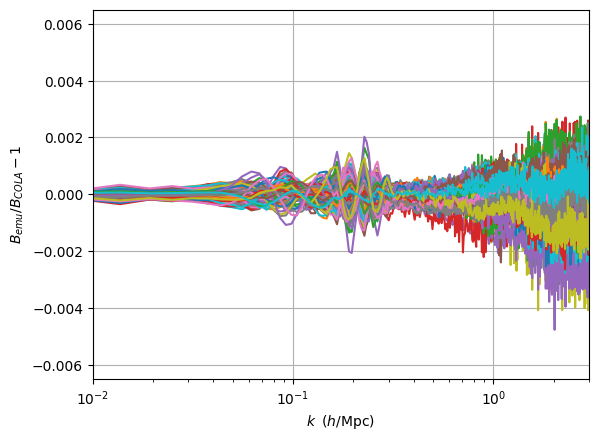

In [101]:
# COLA emulation errors, z=2
z_index = 1
model = keras.models.load_model(f"models/LCDM/NN_Z{redshifts[z_index]:.3f}")
figure, errors = evaluate_model(model, test_samples, test_expqs, z_index, smear=True)

Number of cosmologies with error > 0.005: 1 out of 100


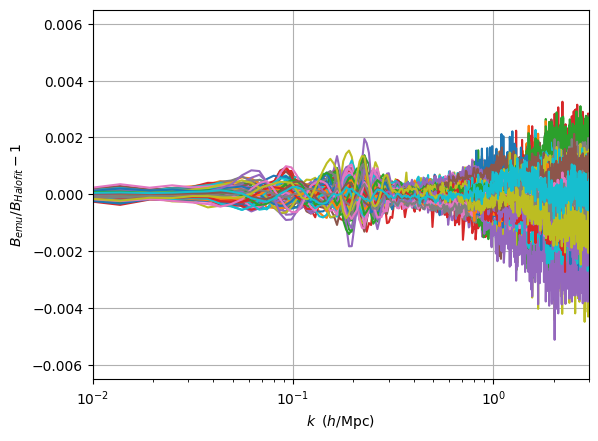

In [71]:
# COLA emulation errors, z=0
figure, errors = evaluate_model(mlp, test_samples, test_expqs, 0, smear=True)

Number of cosmologies with error > 0.005: 0 out of 100


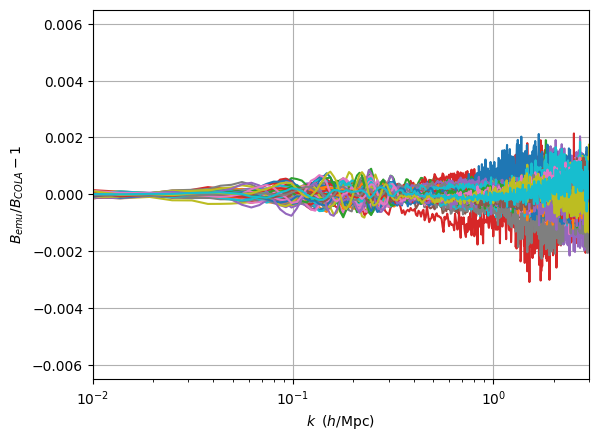

In [113]:
# COLA emulation errors, z=0.5
redshift = redshifts[17]
model = keras.models.load_model(f"./models/LCDM/NN_Z{redshift:.3f}")
figure, errors = evaluate_model(model, test_samples, test_expqs, 17, smear=True)

## Checking whether the Emulator wrapper is working

In [5]:
import nn_emu

In [14]:
cosmo_params = {
    'Omm': 0.31,
    'Omb': 0.05,
    'As': 2.1e-9,
    'ns': 0.97,
    'h': 0.69,
    'mnu': 0.058
}
emu_boost = nn_emu.get_boost(cosmo_params, ks, redshifts)
ks_ee2, ee2_boost = ee2.get_boost(cosmo_params, redshifts, ks)

Missing parameter w0. Will set to -1.
Missing parameter wa. Will set to 0.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.


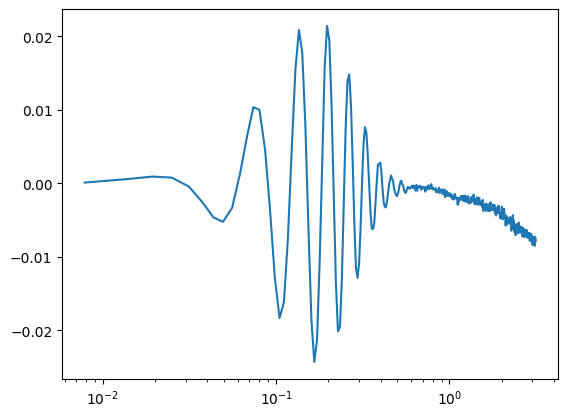

In [16]:
plt.semilogx(ks, emu_boost[0]/ee2_boost[0] - 1)